<a href="https://colab.research.google.com/github/PatchiG/Wildfire-Prediction-Project/blob/main/Wildfire_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Imports and Libraries**

## Libraries

In [ ]:
# General Utilities
import pandas as pd
import numpy as np
import timeit
import sys
import os
import json
import datetime as dt
import scipy
!pip install wget
import wget
import zipfile

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor

# Data Preprocessing and Transformation
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder

# Pipeline and Workflow
from sklearn.pipeline import make_pipeline

# Model Selection and Hyperparameter Tuning
from sklearn.model_selection import (
    TimeSeriesSplit, GroupShuffleSplit, RepeatedKFold, cross_val_score,
    train_test_split, GridSearchCV, RandomizedSearchCV
)

# Metrics and Evaluation
from sklearn.metrics import (
    r2_score, accuracy_score, mean_absolute_error, mean_squared_error,
    classification_report, ConfusionMatrixDisplay
)

# Feature Importance
from sklearn.inspection import permutation_importance

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=231f26f0b56c5cf30c699077efa6fc078f0e7788e41c4047775c27f6b3ad0228
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.7 MB/s eta 0:00:00


## Data Import

In [ ]:
wget.download('https://raw.githubusercontent.com/PatchiG/Wildfires-Datasets/main/data/Jan_23.zip',
                  'Jan_23.zip')
zip_handle = zipfile.ZipFile("Jan_23.zip")
zip_handle.extractall()

In [ ]:
with zipfile.ZipFile("Jan_23.zip", 'r') as zip_handle:
    zip_handle.extractall("extracted_data")  # Extract to a specific directory

# List the files in the extracted directory
extracted_files = os.listdir("extracted_data")

# Print the list of extracted files
print(extracted_files)

['__MACOSX', 'Jan_23']


# **Datasets**

Datasets -
*   Historical Wildfire: Daily aggregation of recorded wildfires in Australia (no Anthropogenic activities).
*   Historical Weather: Daily aggregation of actual record weather phenomenon in Australia.
*   Historical Weather Forecasts: Daily aggregation of various weather phenomenon forecasted with lead time.
*   Landclasses: Classification of Australian landclasses (static data).
*   Vegetation Index: Classification of spread of different vegetation across Australia.

# **Exploratory Data Analysis**

## Historical Wildfires EDA



In [ ]:
file_wildfires = "Jan_23/Historical_Wildfires.csv"
print("Reading file: '{}'".format(file_wildfires))
wildfire_df = pd.read_csv(file_wildfires)

wildfire_df.head()

Reading file: 'Jan_23/Historical_Wildfires.csv'


Region      Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
0    NSW  1/4/2005              8.68000                      312.266667   
1    NSW  1/5/2005             16.61125                      322.475000   
2    NSW  1/6/2005              5.52000                      325.266667   
3    NSW  1/7/2005              6.26400                      313.870000   
4    NSW  1/8/2005              5.40000                      337.383333   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            42.400000        78.666667        2.886751   
1                            62.362500        85.500000        8.088793   
2                            38.400000        78.333333        3.214550   
3                            33.800000        92.200000        7.529940   
4                           122.533333        91.000000        7.937254   

   Var_confidence  Count Replaced  
0        8.333333      3        R  
1       65.428571      8        R  
2       10.333333      3        R  
3       56.700000      5        R  
4       63.000000      3        R

In [ ]:
num_rows, num_cols = wildfire_df.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(wildfire_df.columns)))

There are total 26719 records in the following 10 columns:

Region
Date
Estimated_fire_area
Mean_estimated_fire_brightness
Mean_estimated_fire_radiative_power
Mean_confidence
Std_confidence
Var_confidence
Count
Replaced


From the data:
1. Region: the 7 regions
2. Date: in UTC and provide the data for 24 hours ahead
3. Estimated_fire_area: daily sum of estimated fire area for presumed vegetation fires with a confidence > 75% for a each region in km 2
4. Mean_estimated_fire_brightness: daily mean (by flagged fire pixels(=count)) of estimated fire brightness for presumed vegetation fires with a confidence level > 75% in Kelvin
5. Mean_estimated_fire_radiative_power: daily mean of estimated radiative power for presumed vegetation fires with a confidence level > 75% for a given region in megawatts
6. Mean_confidence: daily mean of confidence for presumed vegetation fires with a confidence level > 75%
7. Std_confidence: standard deviation of estimated fire radiative power in megawatts
8. Var_confidence: Variance of estimated fire radiative power in megawatts
9. Count: daily numbers of pixels for presumed vegetation fires with a confidence level of larger than 75% for a given region
10. Replaced: Indicates with an Y whether the data has been replaced with standard quality data when they are available (usually with a 2-3 month lag). Replaced data has a slightly higher quality in terms of locations

In [ ]:
wildfire_df.describe()

Estimated_fire_area  Mean_estimated_fire_brightness  \
count         26719.000000                    26719.000000   
mean            143.634199                      319.708244   
std             313.203078                        8.895219   
min               1.000000                      290.700000   
25%               8.815000                      313.952652   
50%              38.143636                      319.834524   
75%             146.277390                      325.467990   
max           10120.943170                      381.950000   

       Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
count                         26719.000000     26719.000000    24471.000000   
mean                             83.660705        87.579075        7.228125   
std                              67.793807         4.376509        1.998309   
min                               0.000000        76.000000        0.000000   
25%                              44.102803        85.000000        6.685650   
50%                              67.100000        87.777778        7.707315   
75%                             103.148413        90.500000        8.239119   
max                            2178.600000       100.000000       16.970563   

       Var_confidence         Count  
count    24471.000000  26719.000000  
mean        56.238866     71.754968  
std         25.932027    150.437873  
min          0.000000      1.000000  
25%         44.697917      5.000000  
50%         59.402702     20.000000  
75%         67.883076     74.000000  
max        288.000000   3954.000000

In [ ]:
print(wildfire_df.dtypes)

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
dtype: object


In [ ]:
wildfire_df['Date'] = pd.to_datetime(wildfire_df['Date'])
print("Minimum date: ", wildfire_df['Date'].min())
print("Maximum date: ", wildfire_df['Date'].max())

Minimum date:  2005-01-01 00:00:00
Maximum date:  2021-01-22 00:00:00


In [ ]:
wildfire_df.isna().sum()

Region                                    0
Date                                      0
Estimated_fire_area                       0
Mean_estimated_fire_brightness            0
Mean_estimated_fire_radiative_power       0
Mean_confidence                           0
Std_confidence                         2248
Var_confidence                         2248
Count                                     0
Replaced                                  0
dtype: int64

In [ ]:
wildfire_df.loc[(wildfire_df.Std_confidence.isna()) | (wildfire_df.Var_confidence.isna()), :]

Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
48       NSW 2005-02-26                 1.00                          303.15   
149      NSW 2005-06-12                 1.00                          302.55   
154      NSW 2005-06-18                 5.27                          301.30   
157      NSW 2005-06-25                 9.60                          300.70   
163      NSW 2005-07-09                 2.80                          294.65   
...      ...        ...                  ...                             ...   
26564     WA 2020-08-13                 1.10                          320.35   
26565     WA 2020-08-14                 1.00                          302.15   
26568     WA 2020-08-20                 1.92                          326.85   
26570     WA 2020-08-22                 2.47                          321.10   
26704     WA 2021-01-08                 5.44                          327.20   

       Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
48                                     8.0             79.0             NaN   
149                                   17.9             79.0             NaN   
154                                   71.9             77.0             NaN   
157                                  145.9             76.0             NaN   
163                                   37.8             79.0             NaN   
...                                    ...              ...             ...   
26564                                 27.1             83.0             NaN   
26565                                 15.8             77.0             NaN   
26568                                 86.2             92.0             NaN   
26570                                 43.9             79.0             NaN   
26704                                154.1             82.0             NaN   

       Var_confidence  Count Replaced  
48                NaN      1        R  
149               NaN      1        R  
154               NaN      1        R  
157               NaN      1        R  
163               NaN      1        R  
...               ...    ...      ...  
26564             NaN      1        N  
26565             NaN      1        N  
26568             NaN      1        N  
26570             NaN      1        N  
26704             NaN      1        N  

[2248 rows x 10 columns]

It is clear that the null values in both the fields are appearing at the same data points. That means the Standard Deviation and Variance must have been same. And the value is 0.

In [ ]:
wildfire_df.loc[wildfire_df['Std_confidence'].isna(), 'Std_confidence'] = 0
wildfire_df.loc[wildfire_df['Var_confidence'].isna(), 'Var_confidence'] = 0

In [ ]:
# Remove Duplicates
wildfire_df.drop_duplicates(inplace=True)

# Reset dataframe index
wildfire_df.reset_index(drop=True, inplace=True)

In [ ]:
print("Total Records:", num_rows)

Total Records: 26719


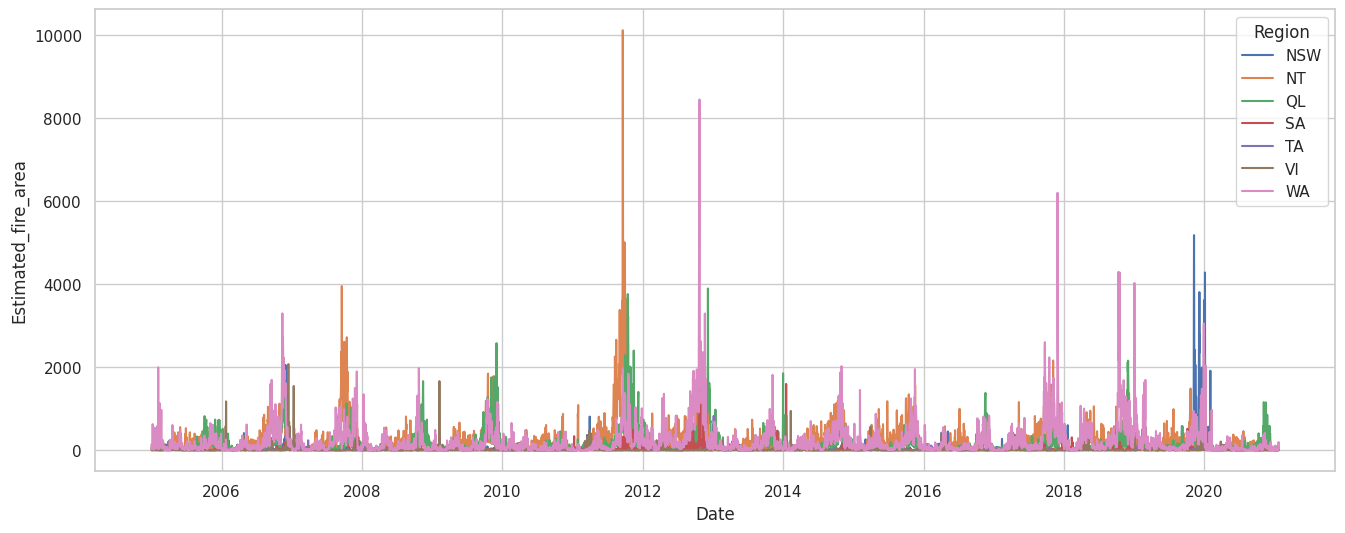

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region', data=wildfire_df)

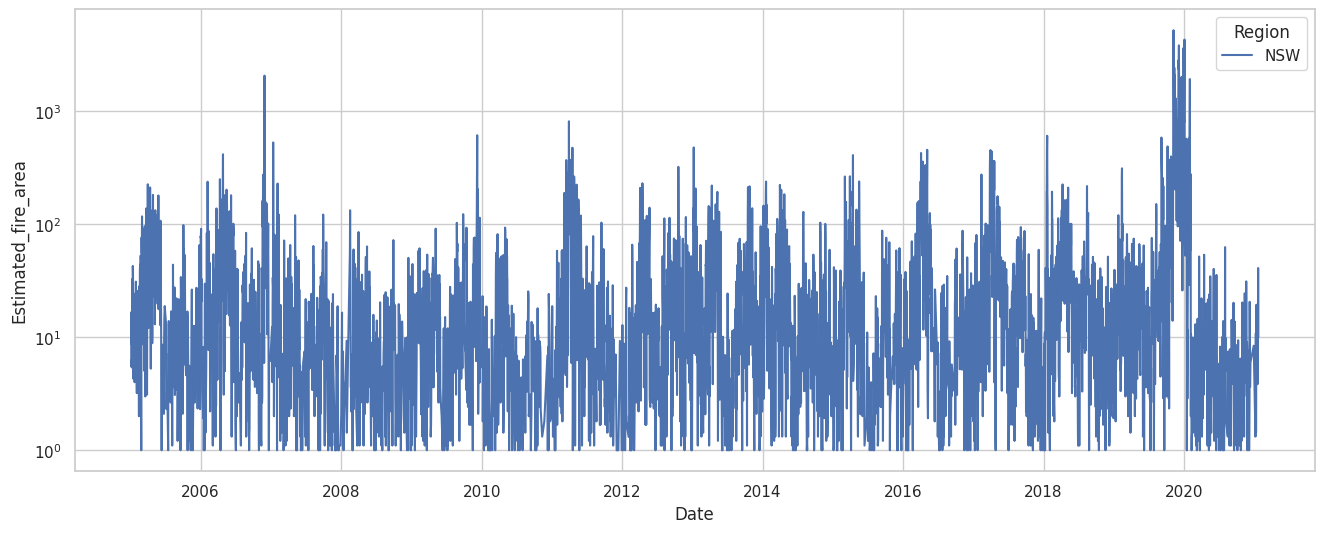

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region', data=wildfire_df[wildfire_df['Region']=='NSW'])
g.set_yscale("log")

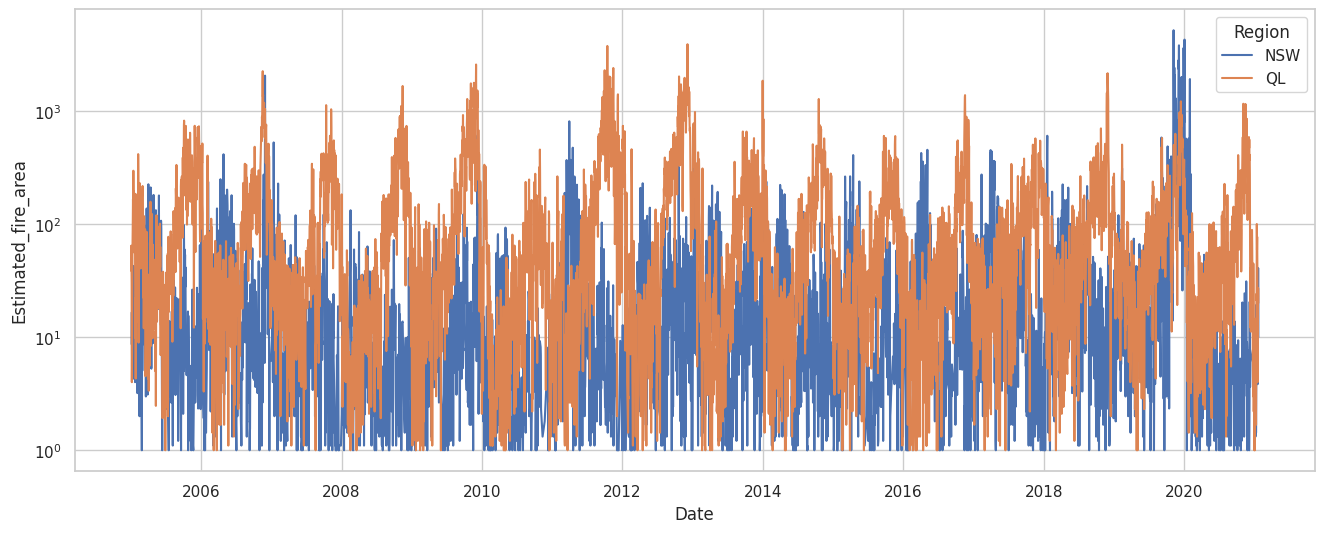

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region', data=wildfire_df[(wildfire_df['Region']=='QL') | (wildfire_df['Region']=='NSW')])
g.set_yscale("log")

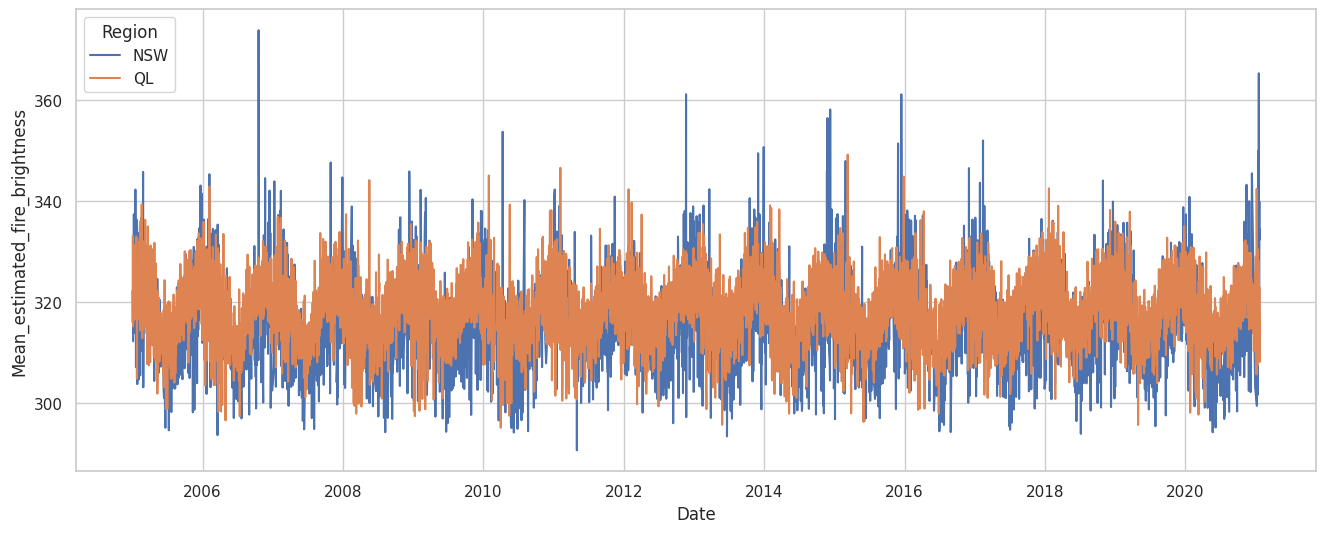

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Mean_estimated_fire_brightness",hue='Region',
                 data=wildfire_df[(wildfire_df['Region']=='QL') |
                  (wildfire_df['Region']=='NSW')])

## Historical Weather Data EDA

In [ ]:
file_weather = "Jan_23/HistoricalWeather.csv"
print("Reading file: '{}'".format(file_weather))
weather_df = pd.read_csv(file_weather)

weather_df.head()

Reading file: 'Jan_23/HistoricalWeather.csv'


Date Region         Parameter  count()[unit: km^2]      min()  \
0  2005-01-01    NSW     Precipitation        800234.348986   0.000000   
1  2005-01-01    NSW  RelativeHumidity        800234.348986  13.877194   
2  2005-01-01    NSW  SoilWaterContent        800234.348986   0.002245   
3  2005-01-01    NSW    SolarRadiation        800234.348986  14.515009   
4  2005-01-01    NSW       Temperature        800234.348986  14.485785   

       max()     mean()  variance()  
0   1.836935   0.044274    0.028362  
1  80.522964  36.355567  253.559937  
2   0.414305   0.170931    0.007758  
3  32.169781  26.749389    6.078587  
4  35.878704  27.341182   18.562212

In [ ]:
num_rows, num_cols = weather_df.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(weather_df.columns)))

There are total 245973 records in the following 8 columns:

Date
Region
Parameter
count()[unit: km^2]
min()
max()
mean()
variance()


From the data:
1. All variables are aggregated to daily values from YYYY-mm-ddT01:00:00Z to YYYY-mm-(dd+1)T00:00:00Z
2. Precipitation is derived from total precipitation. Hourly raw data is converted from m/hour to mm/hour
3. Relative humidity is derived from the temperature and dewpoint
4. Soil water content is given for 0 - 7 cm below the surface
5. Solar radiationor Surface Solar Radiation Downwards. Units are converted from J/h to MJ/h
6. Temperature
7. Wind speed is calculated for every hour from the Easterly and Northerly 10 meter wind components


In [ ]:
# Let rename columns names
weather_df.columns = ['Date', 'Region', 'Parameter', 'area', 'min', 'max', 'mean', '2nd_moment']
weather_df.head()

Date Region         Parameter           area        min        max  \
0  2005-01-01    NSW     Precipitation  800234.348986   0.000000   1.836935   
1  2005-01-01    NSW  RelativeHumidity  800234.348986  13.877194  80.522964   
2  2005-01-01    NSW  SoilWaterContent  800234.348986   0.002245   0.414305   
3  2005-01-01    NSW    SolarRadiation  800234.348986  14.515009  32.169781   
4  2005-01-01    NSW       Temperature  800234.348986  14.485785  35.878704   

        mean  2nd_moment  
0   0.044274    0.028362  
1  36.355567  253.559937  
2   0.170931    0.007758  
3  26.749389    6.078587  
4  27.341182   18.562212

In [ ]:
weather_df.describe()

area           min            max           mean     2nd_moment
count  2.459730e+05  2.459730e+05  245973.000000  245973.000000  245973.000000
mean   1.100786e+06  9.539547e+00      27.264303      16.695978      39.198525
std    7.955005e+05  1.454924e+01      31.343396      21.025146      95.081164
min    6.778526e+04 -5.055067e+00       0.000000       0.000000       0.000000
25%    2.294532e+05  7.669441e-07       5.507898       0.342136       0.346276
50%    9.913151e+05  2.374459e+00      15.583986       6.727405       2.967048
75%    1.730605e+06  1.412678e+01      32.159985      25.068548      16.642380
max    2.528546e+06  9.027615e+01     509.833069      95.952998    2064.896879

In [ ]:
# Checking data types of each columns
weather_df.dtypes

Date           object
Region         object
Parameter      object
area          float64
min           float64
max           float64
mean          float64
2nd_moment    float64
dtype: object

In [ ]:
# Converting "Date" column to date type
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
print("Minimum Date: {}".format(weather_df['Date'].min()))
print("Maximum Date: {}".format(weather_df['Date'].max()))

Minimum Date: 2005-01-01 00:00:00
Maximum Date: 2021-01-18 00:00:00


In [ ]:
weather_df.isna().sum()

Date          0
Region        0
Parameter     0
area          0
min           0
max           0
mean          0
2nd_moment    0
dtype: int64

In [ ]:
df_pivot = weather_df.pivot_table(values=['min','max','mean','2nd_moment'], index=['Date','Region', 'area'], columns=['Parameter'])
df_pivot

2nd_moment                   \
Parameter                      Precipitation RelativeHumidity   
Date       Region area                                          
2005-01-01 NSW    8.002343e+05      0.028362       253.559937   
           NT     1.357561e+06    546.059262       584.201131   
           QL     1.730605e+06     35.641257       403.134377   
           SA     9.913151e+05      0.042837       246.044713   
           TA     6.778526e+04     12.068597       111.754034   
...                                      ...              ...   
2021-01-18 QL     1.730605e+06    170.142419       577.310477   
           SA     9.913151e+05      0.000595       264.546596   
           TA     6.778526e+04      2.666436        62.299884   
           VI     2.294532e+05      0.063535       102.314777   
           WA     2.528546e+06      0.537943       241.147935   

                                                                            \
Parameter                      SoilWaterContent SolarRadiation Temperature   
Date       Region area                                                       
2005-01-01 NSW    8.002343e+05         0.007758       6.078587   18.562212   
           NT     1.357561e+06         0.026743      58.942658   12.920252   
           QL     1.730605e+06         0.012679      29.500832   13.792599   
           SA     9.913151e+05         0.001917       7.914246   34.799336   
           TA     6.778526e+04         0.007121      12.826400    4.912013   
...                                         ...            ...         ...   
2021-01-18 QL     1.730605e+06         0.012677      33.681329   12.487396   
           SA     9.913151e+05         0.001405       1.779273   14.022957   
           TA     6.778526e+04         0.008945      26.783078    5.246669   
           VI     2.294532e+05         0.005246      15.245966    6.100233   
           WA     2.528546e+06         0.001309      24.668831   16.040947   

                                                   max                   \
Parameter                      WindSpeed Precipitation RelativeHumidity   
Date       Region area                                                    
2005-01-01 NSW    8.002343e+05  0.850048      1.836935        80.522964   
           NT     1.357561e+06  1.930014    315.266815        95.683342   
           QL     1.730605e+06  0.883048     74.452164        95.898270   
           SA     9.913151e+05  1.655908      3.193624        81.980751   
           TA     6.778526e+04  2.963118     13.604791        81.501442   
...                                  ...           ...              ...   
2021-01-18 QL     1.730605e+06  1.489574    123.589638        96.995117   
           SA     9.913151e+05  0.441578      0.641580        78.058525   
           TA     6.778526e+04  4.890980      5.923707        80.548386   
           VI     2.294532e+05  1.650209      2.398288        80.715721   
           WA     2.528546e+06  1.097464     22.668976        89.552414   

                                                                ...  \
Parameter                      SoilWaterContent SolarRadiation  ...   
Date       Region area                                          ...   
2005-01-01 NSW    8.002343e+05         0.414305      32.169781  ...   
           NT     1.357561e+06         0.496140      31.634459  ...   
           QL     1.730605e+06         0.472416      31.982830  ...   
           SA     9.913151e+05         0.263911      31.734528  ...   
           TA     6.778526e+04         0.368189      33.225517  ...   
...                                         ...            ...  ...   
2021-01-18 QL     1.730605e+06         0.482571      31.928249  ...   
           SA     9.913151e+05         0.276328      32.219017  ...   
           TA     6.778526e+04         0.413248      31.336357  ...   
           VI     2.294532e+05         0.393214      32.507900  ...   
           WA     2.528546e+06         0.338951      32.

In [ ]:
# Reset dataframe index
df_pivot.reset_index(inplace=True)
df_pivot.head()

Date Region          area    2nd_moment                   \
Parameter                                 Precipitation RelativeHumidity   
0         2005-01-01    NSW  8.002343e+05      0.028362       253.559937   
1         2005-01-01     NT  1.357561e+06    546.059262       584.201131   
2         2005-01-01     QL  1.730605e+06     35.641257       403.134377   
3         2005-01-01     SA  9.913151e+05      0.042837       246.044713   
4         2005-01-01     TA  6.778526e+04     12.068597       111.754034   

                                                                          max  \
Parameter SoilWaterContent SolarRadiation Temperature WindSpeed Precipitation   
0                 0.007758       6.078587   18.562212  0.850048      1.836935   
1                 0.026743      58.942658   12.920252  1.930014    315.266815   
2                 0.012679      29.500832   13.792599  0.883048     74.452164   
3                 0.001917       7.914246   34.799336  1.655908      3.193624   
4                 0.007121      12.826400    4.912013  2.963118     13.604791   

           ...             mean                                       \
Parameter  ... SoilWaterContent SolarRadiation Temperature WindSpeed   
0          ...         0.170931      26.749389   27.341182  3.323550   
1          ...         0.167735      19.781791   29.881492  5.296892   
2          ...         0.185641      27.056979   28.842866  3.483753   
3          ...         0.056047      27.142643   30.793675  4.657538   
4          ...         0.211360      26.755711   11.788805  5.408138   

                    min                                                   \
Parameter Precipitation RelativeHumidity SoilWaterContent SolarRadiation   
0              0.000000        13.877194         0.002245      14.515009   
1              0.000000        14.558820         0.000000       2.518120   
2              0.000000        14.443199         0.000000       6.033827   
3              0.000000        10.618136         0.000000      17.861103   
4              0.003973        43.906574         0.000000      20.742302   

                                 
Parameter Temperature WindSpeed  
0           14.485785  1.354448  
1           24.179960  1.840394  
2           20.951620  1.106028  
3           14.095855  2.023657  
4            6.686816  1.995647  

[5 rows x 27 columns]

In [ ]:
# Renaming Column names
df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]
df_pivot.head()

Date Region          area  Precipitation_2nd_moment  \
0 2005-01-01    NSW  8.002343e+05                  0.028362   
1 2005-01-01     NT  1.357561e+06                546.059262   
2 2005-01-01     QL  1.730605e+06                 35.641257   
3 2005-01-01     SA  9.913151e+05                  0.042837   
4 2005-01-01     TA  6.778526e+04                 12.068597   

   RelativeHumidity_2nd_moment  SoilWaterContent_2nd_moment  \
0                   253.559937                     0.007758   
1                   584.201131                     0.026743   
2                   403.134377                     0.012679   
3                   246.044713                     0.001917   
4                   111.754034                     0.007121   

   SolarRadiation_2nd_moment  Temperature_2nd_moment  WindSpeed_2nd_moment  \
0                   6.078587               18.562212              0.850048   
1                  58.942658               12.920252              1.930014   
2                  29.500832               13.792599              0.883048   
3                   7.914246               34.799336              1.655908   
4                  12.826400                4.912013              2.963118   

   Precipitation_max  ...  SoilWaterContent_mean  SolarRadiation_mean  \
0           1.836935  ...               0.170931            26.749389   
1         315.266815  ...               0.167735            19.781791   
2          74.452164  ...               0.185641            27.056979   
3           3.193624  ...               0.056047            27.142643   
4          13.604791  ...               0.211360            26.755711   

   Temperature_mean  WindSpeed_mean  Precipitation_min  RelativeHumidity_min  \
0         27.341182        3.323550           0.000000             13.877194   
1         29.881492        5.296892           0.000000             14.558820   
2         28.842866        3.483753           0.000000             14.443199   
3         30.793675        4.657538           0.000000             10.618136   
4         11.788805        5.408138           0.003973             43.906574   

   SoilWaterContent_min  SolarRadiation_min  Temperature_min  WindSpeed_min  
0              0.002245           14.515009        14.485785       1.354448  
1              0.000000            2.518120        24.179960       1.840394  
2              0.000000            6.033827        20.951620       1.106028  
3              0.000000           17.861103        14.095855       2.023657  
4              0.000000           20.742302         6.686816       1.995647  

[5 rows x 27 columns]

In [ ]:
# Rearranging Data and column
params = df_pivot.columns.tolist()[3:]
params.sort()
weather_data = df_pivot[df_pivot.columns.tolist()[:3] + params].copy()
weather_data.head()

Date Region          area  Precipitation_2nd_moment  \
0 2005-01-01    NSW  8.002343e+05                  0.028362   
1 2005-01-01     NT  1.357561e+06                546.059262   
2 2005-01-01     QL  1.730605e+06                 35.641257   
3 2005-01-01     SA  9.913151e+05                  0.042837   
4 2005-01-01     TA  6.778526e+04                 12.068597   

   Precipitation_max  Precipitation_mean  Precipitation_min  \
0           1.836935            0.044274           0.000000   
1         315.266815            9.884958           0.000000   
2          74.452164            1.453053           0.000000   
3           3.193624            0.059078           0.000000   
4          13.604791            3.099497           0.003973   

   RelativeHumidity_2nd_moment  RelativeHumidity_max  RelativeHumidity_mean  \
0                   253.559937             80.522964              36.355567   
1                   584.201131             95.683342              61.494675   
2                   403.134377             95.898270              47.959364   
3                   246.044713             81.980751              30.057683   
4                   111.754034             81.501442              65.086764   

   ...  SolarRadiation_mean  SolarRadiation_min  Temperature_2nd_moment  \
0  ...            26.749389           14.515009               18.562212   
1  ...            19.781791            2.518120               12.920252   
2  ...            27.056979            6.033827               13.792599   
3  ...            27.142643           17.861103               34.799336   
4  ...            26.755711           20.742302                4.912013   

   Temperature_max  Temperature_mean  Temperature_min  WindSpeed_2nd_moment  \
0        35.878704         27.341182        14.485785              0.850048   
1        38.136787         29.881492        24.179960              1.930014   
2        37.047943         28.842866        20.951620              0.883048   
3        38.326847         30.793675        14.095855              1.655908   
4        16.228510         11.788805         6.686816              2.963118   

   WindSpeed_max  WindSpeed_mean  WindSpeed_min  
0       7.670482        3.323550       1.354448  
1       9.704402        5.296892       1.840394  
2       7.675632        3.483753       1.106028  
3      10.044715        4.657538       2.023657  
4      11.432408        5.408138       1.995647  

[5 rows x 27 columns]

In [ ]:
num_rows, num_cols = weather_data.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(weather_data.columns)))

There are total 41013 records in the following 27 columns:

Date
Region
area
Precipitation_2nd_moment
Precipitation_max
Precipitation_mean
Precipitation_min
RelativeHumidity_2nd_moment
RelativeHumidity_max
RelativeHumidity_mean
RelativeHumidity_min
SoilWaterContent_2nd_moment
SoilWaterContent_max
SoilWaterContent_mean
SoilWaterContent_min
SolarRadiation_2nd_moment
SolarRadiation_max
SolarRadiation_mean
SolarRadiation_min
Temperature_2nd_moment
Temperature_max
Temperature_mean
Temperature_min
WindSpeed_2nd_moment
WindSpeed_max
WindSpeed_mean
WindSpeed_min


In [ ]:
weather_data.isna().sum()

Date                            0
Region                          0
area                            0
Precipitation_2nd_moment        7
Precipitation_max               7
Precipitation_mean              7
Precipitation_min               7
RelativeHumidity_2nd_moment    42
RelativeHumidity_max           42
RelativeHumidity_mean          42
RelativeHumidity_min           42
SoilWaterContent_2nd_moment     0
SoilWaterContent_max            0
SoilWaterContent_mean           0
SoilWaterContent_min            0
SolarRadiation_2nd_moment      14
SolarRadiation_max             14
SolarRadiation_mean            14
SolarRadiation_min             14
Temperature_2nd_moment         14
Temperature_max                14
Temperature_mean               14
Temperature_min                14
WindSpeed_2nd_moment           28
WindSpeed_max                  28
WindSpeed_mean                 28
WindSpeed_min                  28
dtype: int64

In [ ]:
weather_data.loc[weather_data['Precipitation_mean'].isna(), :]

Date Region          area  Precipitation_2nd_moment  \
36995 2019-06-22    NSW  8.002343e+05                       NaN   
36996 2019-06-22     NT  1.357561e+06                       NaN   
36997 2019-06-22     QL  1.730605e+06                       NaN   
36998 2019-06-22     SA  9.913151e+05                       NaN   
36999 2019-06-22     TA  6.778526e+04                       NaN   
37000 2019-06-22     VI  2.294532e+05                       NaN   
37001 2019-06-22     WA  2.528546e+06                       NaN   

       Precipitation_max  Precipitation_mean  Precipitation_min  \
36995                NaN                 NaN                NaN   
36996                NaN                 NaN                NaN   
36997                NaN                 NaN                NaN   
36998                NaN                 NaN                NaN   
36999                NaN                 NaN                NaN   
37000                NaN                 NaN                NaN   
37001                NaN                 NaN                NaN   

       RelativeHumidity_2nd_moment  RelativeHumidity_max  \
36995                   114.312088             91.814453   
36996                   125.066021             74.113892   
36997                   136.242906             83.852173   
36998                   189.151252             90.240486   
36999                    38.487720             97.402702   
37000                    41.199200             96.209885   
37001                   467.014533             98.127876   

       RelativeHumidity_mean  ...  SolarRadiation_mean  SolarRadiation_min  \
36995              68.422677  ...            11.564692            5.427815   
36996              30.802208  ...            17.438541           12.637497   
36997              46.585385  ...            16.071312           10.554407   
36998              50.957245  ...            12.181231            6.261038   
36999              86.778359  ...             5.854250            4.417063   
37000              84.582572  ...             7.781152            5.230695   
37001              39.120916  ...            11.886737            2.460803   

       Temperature_2nd_moment  Temperature_max  Temperature_mean  \
36995                4.957193        13.923991          6.138674   
36996               17.841910        25.157646         14.323231   
36997               22.149479        25.403965         11.880667   
36998                2.724242        13.625819          8.601456   
36999                6.325362        11.469337          4.574910   
37000                3.685770        11.801810          5.001564   
37001                6.561743        24.897877         18.152780   

       Temperature_min  WindSpeed_2nd_moment  WindSpeed_max  WindSpeed_mean  \
36995        -0.300265              0.670847       9.339998        2.914745   
36996         7.124587              0.821780       9.785229        4.616783   
36997         4.738083              1.266645       9.982671        3.428681   
36998         2.367725              1.113020       8.605908        3.424624   
36999        -0.214279              0.857406       6.195638        1.771625   
37000         0.078639              0.361891       6.246301        2.101499   
37001        11.241782              1.324167       8.518429        4.775665   

       WindSpeed_min  
36995       1.048711  
36996       2.790959  
36997       1.280596  
36998       1.245013  
36999       0.696300  
37000       0.802938  
37001       2.197379  

[7 rows x 27 columns]

It seems like there was no Precipitation on 2019-06-22 in all 7 regions. Lets check the values in Original data.

In [ ]:
weather_df.loc[weather_df['Date'] == "2019-06-22", :]

Date Region         Parameter          area        min  \
221893 2019-06-22    NSW  RelativeHumidity  8.002343e+05  47.983139   
221894 2019-06-22    NSW  SoilWaterContent  8.002343e+05   0.000723   
221895 2019-06-22    NSW    SolarRadiation  8.002343e+05   5.427815   
221896 2019-06-22    NSW       Temperature  8.002343e+05  -0.300265   
221897 2019-06-22    NSW         WindSpeed  8.002343e+05   1.048711   
221898 2019-06-22     NT  RelativeHumidity  1.357561e+06  17.733223   
221899 2019-06-22     NT  SoilWaterContent  1.357561e+06   0.000000   
221900 2019-06-22     NT    SolarRadiation  1.357561e+06  12.637497   
221901 2019-06-22     NT       Temperature  1.357561e+06   7.124587   
221902 2019-06-22     NT         WindSpeed  1.357561e+06   2.790959   
221903 2019-06-22     QL  RelativeHumidity  1.730605e+06  21.653999   
221904 2019-06-22     QL  SoilWaterContent  1.730605e+06   0.000000   
221905 2019-06-22     QL    SolarRadiation  1.730605e+06  10.554407   
221906 2019-06-22     QL       Temperature  1.730605e+06   4.738083   
221907 2019-06-22     QL         WindSpeed  1.730605e+06   1.280596   
221908 2019-06-22     SA  RelativeHumidity  9.913151e+05  22.742420   
221909 2019-06-22     SA  SoilWaterContent  9.913151e+05   0.000000   
221910 2019-06-22     SA    SolarRadiation  9.913151e+05   6.261038   
221911 2019-06-22     SA       Temperature  9.913151e+05   2.367725   
221912 2019-06-22     SA         WindSpeed  9.913151e+05   1.245013   
221913 2019-06-22     TA  RelativeHumidity  6.778526e+04  68.310066   
221914 2019-06-22     TA  SoilWaterContent  6.778526e+04   0.000000   
221915 2019-06-22     TA    SolarRadiation  6.778526e+04   4.417063   
221916 2019-06-22     TA       Temperature  6.778526e+04  -0.214279   
221917 2019-06-22     TA         WindSpeed  6.778526e+04   0.696300   
221918 2019-06-22     VI  RelativeHumidity  2.294532e+05  63.882984   
221919 2019-06-22     VI  SoilWaterContent  2.294532e+05   0.000000   
221920 2019-06-22     VI    SolarRadiation  2.294532e+05   5.230695   
221921 2019-06-22     VI       Temperature  2.294532e+05   0.078639   
221922 2019-06-22     VI         WindSpeed  2.294532e+05   0.802938   
221923 2019-06-22     WA  RelativeHumidity  2.528546e+06  14.851243   
221924 2019-06-22     WA  SoilWaterContent  2.528546e+06   0.000000   
221925 2019-06-22     WA    SolarRadiation  2.528546e+06   2.460803   
221926 2019-06-22     WA       Temperature  2.528546e+06  11.241782   
221927 2019-06-22     WA         WindSpeed  2.528546e+06   2.197379   

              max       mean  2nd_moment  
221893  91.814453  68.422677  114.312088  
221894   0.412930   0.206911    0.008979  
221895  14.121369  11.564692    2.390587  
221896  13.923991   6.138674    4.957193  
221897   9.339998   2.914745    0.670847  
221898  74.113892  30.802208  125.066021  
221899   0.264075   0.067087    0.003592  
221900  20.044704  17.438541    2.493807  
221901  25.157646  14.323231   17.841910  
221902   9.785229   4.616783    0.821780  
221903  83.852173  46.585385  136.242906  
221904   0.407056   0.145537    0.004564  
221905  18.989447  16.071312    2.541980  
221906  25.403965  11.880667   22.149479  
221907   9.982671   3.428681    1.266645  
221908  90.240486  50.957245  189.151252  
221909   0.442534   0.085350    0.006496  
221910  14.702800  12.181231    2.518352  
221911  13.625819   8.601456    2.724242  
221912   8.605908   3.424624    1.113020  
221913  97.402702  86.778359   38.487720  
221914   0.388888   0.287726    0.008860  
221915   8.307443   5.854250    1.139942  
221916  11.469337   4.574910    6.325362  
221917   6.195638   1.771625    0.857406  
221918  96.209885  84.582572   41.199200  
221919   0.469960   0.319544    0.006050  
221920  10.392207   7.781152    1.509120  
221921  11.801810   5.001564    3.685770  
221922   6.246301   2.101499    0.361891  
221923  98.127876  39.120916  467.014533  
221924   0.369130   0.074549    0.004804  
221925  19.167070  11.886737   13.936

From original data, it confirms that there was no rain on 2019-06-22

In [ ]:
weather_data.isna().sum()

Date                            0
Region                          0
area                            0
Precipitation_2nd_moment        7
Precipitation_max               7
Precipitation_mean              7
Precipitation_min               7
RelativeHumidity_2nd_moment    42
RelativeHumidity_max           42
RelativeHumidity_mean          42
RelativeHumidity_min           42
SoilWaterContent_2nd_moment     0
SoilWaterContent_max            0
SoilWaterContent_mean           0
SoilWaterContent_min            0
SolarRadiation_2nd_moment      14
SolarRadiation_max             14
SolarRadiation_mean            14
SolarRadiation_min             14
Temperature_2nd_moment         14
Temperature_max                14
Temperature_mean               14
Temperature_min                14
WindSpeed_2nd_moment           28
WindSpeed_max                  28
WindSpeed_mean                 28
WindSpeed_min                  28
dtype: int64

Now, let's check Mean Temperature NULL values

In [ ]:
weather_data.loc[weather_data['Temperature_mean'].isna(), :]

Date Region          area  Precipitation_2nd_moment  \
10493 2009-02-08    NSW  8.002343e+05                  0.111808   
10494 2009-02-08     NT  1.357561e+06                120.248699   
10495 2009-02-08     QL  1.730605e+06                279.584007   
10496 2009-02-08     SA  9.913151e+05                  0.005040   
10497 2009-02-08     TA  6.778526e+04                  1.719551   
10498 2009-02-08     VI  2.294532e+05                  0.502153   
10499 2009-02-08     WA  2.528546e+06                  4.710052   
34419 2018-06-19    NSW  8.002343e+05                  2.780286   
34420 2018-06-19     NT  1.357561e+06                  0.000539   
34421 2018-06-19     QL  1.730605e+06                  0.011031   
34422 2018-06-19     SA  9.913151e+05                  2.659250   
34423 2018-06-19     TA  6.778526e+04                  0.019208   
34424 2018-06-19     VI  2.294532e+05                  0.109241   
34425 2018-06-19     WA  2.528546e+06                  0.575247   

       Precipitation_max  Precipitation_mean  Precipitation_min  \
10493           3.443802            0.096440                0.0   
10494          80.331871            7.512906                0.0   
10495         176.865433            9.807672                0.0   
10496           1.049786            0.015489                0.0   
10497           6.913176            1.033623                0.0   
10498           5.414611            0.361654                0.0   
10499          22.894337            0.710461                0.0   
34419          28.754610            0.347647                0.0   
34420           1.732284            0.001350                0.0   
34421           2.666157            0.010751                0.0   
34422           8.953135            0.783627                0.0   
34423           1.108830            0.052225                0.0   
34424           3.243635            0.070975                0.0   
34425           6.116549            0.218917                0.0   

       RelativeHumidity_2nd_moment  RelativeHumidity_max  \
10493                          NaN                   NaN   
10494                          NaN                   NaN   
10495                          NaN                   NaN   
10496                          NaN                   NaN   
10497                          NaN                   NaN   
10498                          NaN                   NaN   
10499                          NaN                   NaN   
34419                          NaN                   NaN   
34420                          NaN                   NaN   
34421                          NaN                   NaN   
34422                          NaN                   NaN   
34423                          NaN                   NaN   
34424                          NaN                   NaN   
34425                          NaN                   NaN   

       RelativeHumidity_mean  ...  SolarRadiation_mean  SolarRadiation_min  \
10493                    NaN  ...            28.499942           18.516203   
10494                    NaN  ...            21.338024            5.833764   
10495                    NaN  ...            19.476571            2.483397   
10496                    NaN  ...            27.299430           16.878788   
10497                    NaN  ...            21.995847           16.771393   
10498                    NaN  ...            24.609960           17.236010   
10499                    NaN  ...            26.453286           14.515725   
34419                    NaN  ...            10.198048            3.253069   
34420                    NaN  ...            17.050411           11.142137   
34421                    NaN  ...            16.228667            8.911916   
34422                    NaN  ...             9.205824            2.152358   
34423                    NaN  ...             6.595320            5.016344   
34424                    NaN  ...             8.292782            3.819396   
34425  

In [ ]:
weather_df.loc[weather_df['Date'] == "2009-02-08", :]

Date Region         Parameter          area           min  \
62951 2009-02-08    NSW     Precipitation  8.002343e+05  0.000000e+00   
62952 2009-02-08    NSW  SoilWaterContent  8.002343e+05  1.704425e-02   
62953 2009-02-08    NSW    SolarRadiation  8.002343e+05  1.851620e+01   
62954 2009-02-08    NSW         WindSpeed  8.002343e+05  1.108891e+00   
62955 2009-02-08     NT     Precipitation  1.357561e+06  0.000000e+00   
62956 2009-02-08     NT  SoilWaterContent  1.357561e+06  6.010911e-07   
62957 2009-02-08     NT    SolarRadiation  1.357561e+06  5.833764e+00   
62958 2009-02-08     NT         WindSpeed  1.357561e+06  9.889196e-01   
62959 2009-02-08     QL     Precipitation  1.730605e+06  0.000000e+00   
62960 2009-02-08     QL  SoilWaterContent  1.730605e+06  6.010911e-07   
62961 2009-02-08     QL    SolarRadiation  1.730605e+06  2.483397e+00   
62962 2009-02-08     QL         WindSpeed  1.730605e+06  6.388955e-01   
62963 2009-02-08     SA     Precipitation  9.913151e+05  0.000000e+00   
62964 2009-02-08     SA  SoilWaterContent  9.913151e+05  6.010911e-07   
62965 2009-02-08     SA    SolarRadiation  9.913151e+05  1.687879e+01   
62966 2009-02-08     SA         WindSpeed  9.913151e+05  1.923652e+00   
62967 2009-02-08     TA     Precipitation  6.778526e+04  0.000000e+00   
62968 2009-02-08     TA  SoilWaterContent  6.778526e+04  6.010911e-07   
62969 2009-02-08     TA    SolarRadiation  6.778526e+04  1.677139e+01   
62970 2009-02-08     TA         WindSpeed  6.778526e+04  2.525351e+00   
62971 2009-02-08     VI     Precipitation  2.294532e+05  0.000000e+00   
62972 2009-02-08     VI  SoilWaterContent  2.294532e+05  6.010911e-07   
62973 2009-02-08     VI    SolarRadiation  2.294532e+05  1.723601e+01   
62974 2009-02-08     VI         WindSpeed  2.294532e+05  2.073939e+00   
62975 2009-02-08     WA     Precipitation  2.528546e+06  0.000000e+00   
62976 2009-02-08     WA  SoilWaterContent  2.528546e+06  6.010911e-07   
62977 2009-02-08     WA    SolarRadiation  2.528546e+06  1.451573e+01   
62978 2009-02-08     WA         WindSpeed  2.528546e+06  2.050614e+00   

              max       mean  2nd_moment  
62951    3.443802   0.096440    0.111808  
62952    0.383857   0.149632    0.004283  
62953   31.312689  28.499942    4.225705  
62954    9.101792   3.861615    3.195680  
62955   80.331871   7.512906  120.248699  
62956    0.494226   0.178735    0.025239  
62957   30.037846  21.338024   40.175295  
62958   10.320077   4.139762    3.405661  
62959  176.865433   9.807672  279.584007  
62960    0.512477   0.253117    0.020698  
62961   30.783705  19.476571   96.336519  
62962    8.917587   3.688307    1.510411  
62963    1.049786   0.015489    0.005040  
62964    0.256353   0.060546    0.001751  
62965   30.332903  27.299430   10.573555  
62966   11.238954   6.878877    2.527251  
62967    6.913176   1.033623    1.719551  
62968    0.364187   0.229636    0.008394  
62969   26.911438  21.995847    6.214274  
62970   10.531963   4.759034    2.148888  
62971    5.414611   0.361654    0.502153  
62972    0.327845   0.171679    0.003085  
62973   29.266239  24.609960    7.812433  
62974    9.120632   5.007785    1.588085  
62975   22.894337   0.710461    4.710052  
62976    0.477876   0.080486    0.006034  
62977   30.657774  26.453286    9.805221  
62978   10.121881   6.069578    3.458938

In [ ]:
weather_df.loc[weather_df['Date'] == "2018-06-19", :]

Date Region         Parameter          area        min  \
206458 2018-06-19    NSW     Precipitation  8.002343e+05   0.000000   
206459 2018-06-19    NSW  SoilWaterContent  8.002343e+05   0.003328   
206460 2018-06-19    NSW    SolarRadiation  8.002343e+05   3.253069   
206461 2018-06-19    NSW         WindSpeed  8.002343e+05   1.053749   
206462 2018-06-19     NT     Precipitation  1.357561e+06   0.000000   
206463 2018-06-19     NT  SoilWaterContent  1.357561e+06   0.000000   
206464 2018-06-19     NT    SolarRadiation  1.357561e+06  11.142137   
206465 2018-06-19     NT         WindSpeed  1.357561e+06   1.700933   
206466 2018-06-19     QL     Precipitation  1.730605e+06   0.000000   
206467 2018-06-19     QL  SoilWaterContent  1.730605e+06   0.000000   
206468 2018-06-19     QL    SolarRadiation  1.730605e+06   8.911916   
206469 2018-06-19     QL         WindSpeed  1.730605e+06   1.166037   
206470 2018-06-19     SA     Precipitation  9.913151e+05   0.000000   
206471 2018-06-19     SA  SoilWaterContent  9.913151e+05   0.000000   
206472 2018-06-19     SA    SolarRadiation  9.913151e+05   2.152358   
206473 2018-06-19     SA         WindSpeed  9.913151e+05   0.984949   
206474 2018-06-19     TA     Precipitation  6.778526e+04   0.000000   
206475 2018-06-19     TA  SoilWaterContent  6.778526e+04   0.000000   
206476 2018-06-19     TA    SolarRadiation  6.778526e+04   5.016344   
206477 2018-06-19     TA         WindSpeed  6.778526e+04   0.538815   
206478 2018-06-19     VI     Precipitation  2.294532e+05   0.000000   
206479 2018-06-19     VI  SoilWaterContent  2.294532e+05   0.000000   
206480 2018-06-19     VI    SolarRadiation  2.294532e+05   3.819396   
206481 2018-06-19     VI         WindSpeed  2.294532e+05   1.237826   
206482 2018-06-19     WA     Precipitation  2.528546e+06   0.000000   
206483 2018-06-19     WA  SoilWaterContent  2.528546e+06   0.000000   
206484 2018-06-19     WA    SolarRadiation  2.528546e+06   2.245623   
206485 2018-06-19     WA         WindSpeed  2.528546e+06   1.115860   

              max       mean  2nd_moment  
206458  28.754610   0.347647    2.780286  
206459   0.417228   0.213582    0.010501  
206460  13.556427  10.198048    5.565272  
206461   9.898138   2.797399    1.183612  
206462   1.732284   0.001350    0.000539  
206463   0.282540   0.067721    0.003760  
206464  19.234465  17.050411    1.936097  
206465   9.185046   3.272381    0.452138  
206466   2.666157   0.010751    0.011031  
206467   0.367845   0.132323    0.004210  
206468  19.215368  16.228667    3.343518  
206469  11.241320   3.401858    0.713732  
206470   8.953135   0.783627    2.659250  
206471   0.460092   0.094051    0.006477  
206472  14.557941   9.205824   10.442554  
206473   8.164105   3.004946    0.874541  
206474   1.108830   0.052225    0.019208  
206475   0.391972   0.292926    0.009393  
206476   7.349454   6.595320    0.253610  
206477   8.422768   2.610433    2.059339  
206478   3.243635   0.070975    0.109241  
206479   0.464654   0.328054    0.005894  
206480  10.132601   8.292782    1.307302  
206481   6.651026   2.316004    0.646547  
206482   6.116549   0.218917    0.575247  
206483   0.350896   0.111437    0.007163  
206484  18.767883  11.695733   15.904377  
206485   9.204654   3.703516    0.980005

Upon cross check and verification, we can that there are no Temperature readings for all regions on 2009-02-08 and 2018-06-19. In fact, there are no SolarRadiation reading on both dates and regions too.

Hence, these values below, are NULL values because they have no readings in original data.

In [ ]:
weather_data.isna().sum()

Date                            0
Region                          0
area                            0
Precipitation_2nd_moment        7
Precipitation_max               7
Precipitation_mean              7
Precipitation_min               7
RelativeHumidity_2nd_moment    42
RelativeHumidity_max           42
RelativeHumidity_mean          42
RelativeHumidity_min           42
SoilWaterContent_2nd_moment     0
SoilWaterContent_max            0
SoilWaterContent_mean           0
SoilWaterContent_min            0
SolarRadiation_2nd_moment      14
SolarRadiation_max             14
SolarRadiation_mean            14
SolarRadiation_min             14
Temperature_2nd_moment         14
Temperature_max                14
Temperature_mean               14
Temperature_min                14
WindSpeed_2nd_moment           28
WindSpeed_max                  28
WindSpeed_mean                 28
WindSpeed_min                  28
dtype: int64

In [ ]:
weather_data = weather_data.fillna(0).copy()
weather_data.head()

Date Region          area  Precipitation_2nd_moment  \
0 2005-01-01    NSW  8.002343e+05                  0.028362   
1 2005-01-01     NT  1.357561e+06                546.059262   
2 2005-01-01     QL  1.730605e+06                 35.641257   
3 2005-01-01     SA  9.913151e+05                  0.042837   
4 2005-01-01     TA  6.778526e+04                 12.068597   

   Precipitation_max  Precipitation_mean  Precipitation_min  \
0           1.836935            0.044274           0.000000   
1         315.266815            9.884958           0.000000   
2          74.452164            1.453053           0.000000   
3           3.193624            0.059078           0.000000   
4          13.604791            3.099497           0.003973   

   RelativeHumidity_2nd_moment  RelativeHumidity_max  RelativeHumidity_mean  \
0                   253.559937             80.522964              36.355567   
1                   584.201131             95.683342              61.494675   
2                   403.134377             95.898270              47.959364   
3                   246.044713             81.980751              30.057683   
4                   111.754034             81.501442              65.086764   

   ...  SolarRadiation_mean  SolarRadiation_min  Temperature_2nd_moment  \
0  ...            26.749389           14.515009               18.562212   
1  ...            19.781791            2.518120               12.920252   
2  ...            27.056979            6.033827               13.792599   
3  ...            27.142643           17.861103               34.799336   
4  ...            26.755711           20.742302                4.912013   

   Temperature_max  Temperature_mean  Temperature_min  WindSpeed_2nd_moment  \
0        35.878704         27.341182        14.485785              0.850048   
1        38.136787         29.881492        24.179960              1.930014   
2        37.047943         28.842866        20.951620              0.883048   
3        38.326847         30.793675        14.095855              1.655908   
4        16.228510         11.788805         6.686816              2.963118   

   WindSpeed_max  WindSpeed_mean  WindSpeed_min  
0       7.670482        3.323550       1.354448  
1       9.704402        5.296892       1.840394  
2       7.675632        3.483753       1.106028  
3      10.044715        4.657538       2.023657  
4      11.432408        5.408138       1.995647  

[5 rows x 27 columns]

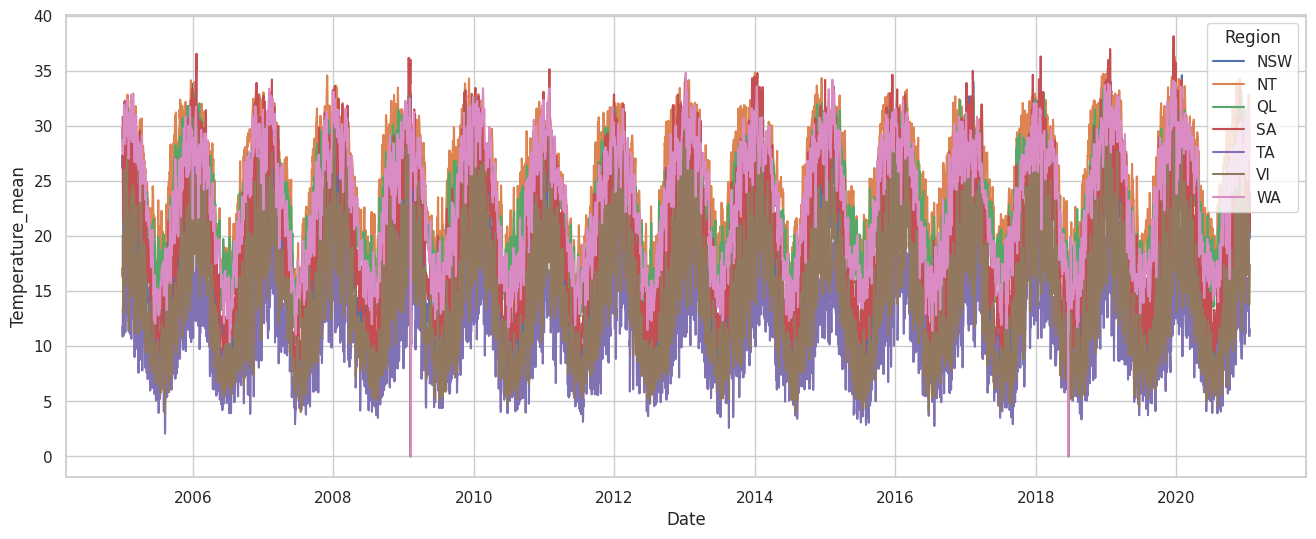

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Temperature_mean", hue='Region', data=weather_data)

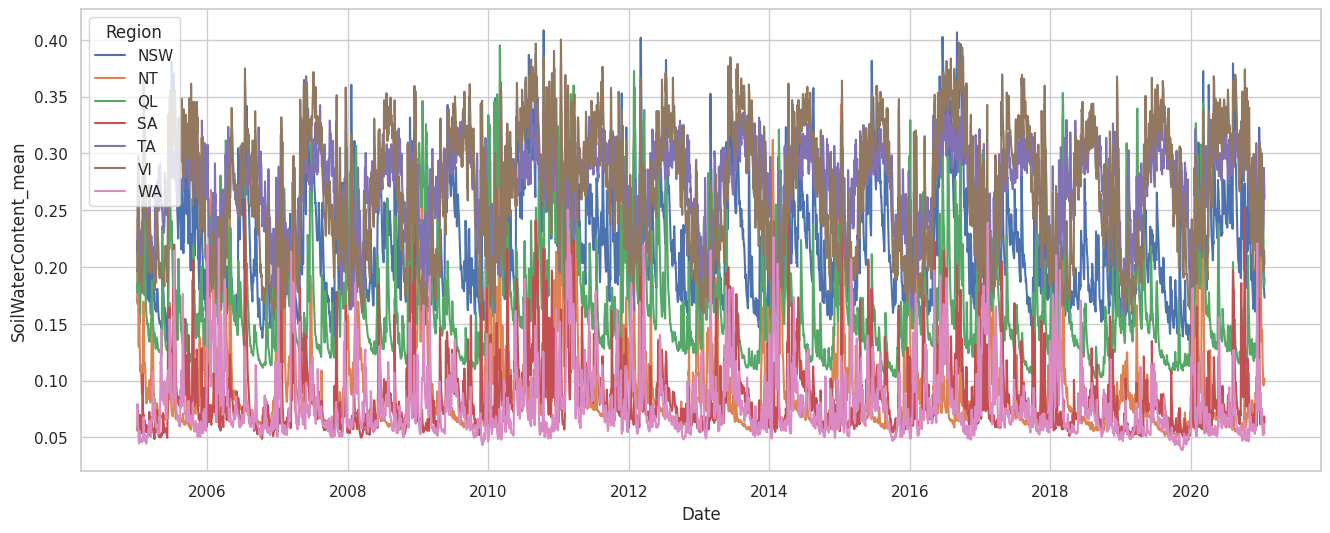

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="SoilWaterContent_mean",hue='Region', data=weather_data)

In [ ]:
weather_data[['Region','area']].round(0).drop_duplicates().sort_values(by=['Region','area']).reset_index(drop=True)

Region       area
0    NSW   800234.0
1     NT  1357561.0
2     QL  1730605.0
3     SA   991315.0
4     TA    67785.0
5     VI   229453.0
6     WA  2528546.0

## Historical Weather Forecasts EDA

In [ ]:
file_weather_forecasts = "Jan_23/HistoricalWeatherForecasts.csv"
print("Reading file: '{}'".format(file_weather_forecasts))
forecasts_df = pd.read_csv(file_weather_forecasts)

forecasts_df.head()

Reading file: 'Jan_23/HistoricalWeatherForecasts.csv'


Date Region         Parameter  Lead time  count()[unit: km^2]  \
0  2014-01-01    NSW  RelativeHumidity          5         8.037682e+05   
1  2014-01-01    NSW    SolarRadiation          5         8.037682e+05   
2  2014-01-01    NSW       Temperature          5         8.037682e+05   
3  2014-01-01    NSW         WindSpeed          5         8.037682e+05   
4  2014-01-01     NT  RelativeHumidity          5         1.349817e+06   

       min()      max()     mean()  variance()  
0   7.482927  85.021118  28.223569  353.620815  
1  24.865765  33.557598  31.647308    2.276068  
2  21.243755  36.929035  30.893523   17.918553  
3   1.593531   6.989559   3.958822    1.334834  
4  14.796251  73.601479  39.799856  189.805002

In [ ]:
forecasts_df.describe()

Lead time  count()[unit: km^2]          min()          max()  \
count  226494.000000         2.264940e+05  226494.000000  226494.000000   
mean        9.689087         1.101103e+06      10.858428      32.900904   
std         4.135975         7.997247e+05      14.582573      54.733919   
min         5.000000         6.567142e+04      -5.018160       0.000000   
25%         5.000000         2.300457e+05       0.778933       9.621831   
50%        10.000000         9.797103e+05       5.574830      22.850920   
75%        15.000000         1.736319e+06      15.653995      36.697441   
max        15.000000         2.542548e+06     254.096924   10001.387695   

              mean()    variance()  
count  226494.000000  2.264940e+05  
mean       19.985720  3.541808e+02  
std        24.744903  7.572256e+04  
min        -0.113379  0.000000e+00  
25%         3.951338  1.831837e+00  
50%        14.971723  6.773274e+00  
75%        28.659193  2.855960e+01  
max      5079.335413  2.373057e+07

In [ ]:
forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])

In [ ]:
# Let rename columns names
forecasts_df.columns = ['Date', 'Region', 'Parameter', 'Lead time', 'area', 'min_forcast', 'max_forcast', 'mean_forcast', '2nd_moment_forcast']
forecasts_df.head()

Date Region         Parameter  Lead time          area  min_forcast  \
0 2014-01-01    NSW  RelativeHumidity          5  8.037682e+05     7.482927   
1 2014-01-01    NSW    SolarRadiation          5  8.037682e+05    24.865765   
2 2014-01-01    NSW       Temperature          5  8.037682e+05    21.243755   
3 2014-01-01    NSW         WindSpeed          5  8.037682e+05     1.593531   
4 2014-01-01     NT  RelativeHumidity          5  1.349817e+06    14.796251   

   max_forcast  mean_forcast  2nd_moment_forcast  
0    85.021118     28.223569          353.620815  
1    33.557598     31.647308            2.276068  
2    36.929035     30.893523           17.918553  
3     6.989559      3.958822            1.334834  
4    73.601479     39.799856          189.805002

In [ ]:
forecasts_df.isna().sum()

Date                  0
Region                0
Parameter             0
Lead time             0
area                  0
min_forcast           0
max_forcast           0
mean_forcast          0
2nd_moment_forcast    0
dtype: int64

In [ ]:
df_pivot = forecasts_df.pivot_table(values=['min_forcast', 'max_forcast', 'mean_forcast', '2nd_moment_forcast'], index=['Date', 'Region', 'Lead time', 'area'], columns=['Parameter'])
df_pivot

2nd_moment_forcast                   \
Parameter                                     Precipitation RelativeHumidity   
Date       Region Lead time area                                               
2014-01-01 NSW    5         8.037682e+05                NaN       353.620815   
           NT     5         1.349817e+06                NaN       189.805002   
           QL     5         1.736319e+06                NaN       470.624907   
           SA     5         9.797103e+05                NaN       275.718715   
           TA     5         6.567142e+04                NaN        12.570180   
...                                                     ...              ...   
2021-02-08 QL     15        1.736319e+06                NaN       166.534783   
           SA     15        9.797103e+05                NaN       129.783106   
           TA     15        6.567142e+04                NaN        18.350878   
           VI     15        2.300457e+05                NaN       342.233012   
           WA     15        2.542548e+06                NaN       265.468332   

                                                                     \
Parameter                                SolarRadiation Temperature   
Date       Region Lead time area                                      
2014-01-01 NSW    5         8.037682e+05       2.276068   17.918553   
           NT     5         1.349817e+06       6.573279    6.605778   
           QL     5         1.736319e+06       7.079362   22.150075   
           SA     5         9.797103e+05      30.069684   15.097683   
           TA     5         6.567142e+04       9.588782    2.292068   
...                                                 ...         ...   
2021-02-08 QL     15        1.736319e+06      13.074358    9.424890   
           SA     15        9.797103e+05       1.288609   12.281596   
           TA     15        6.567142e+04      26.037987    3.787350   
           VI     15        2.300457e+05       0.489770   12.571592   
           WA     15        2.542548e+06      38.201263    8.009884   

                                                      max_forcast  \
Parameter                                 WindSpeed Precipitation   
Date       Region Lead time area                                    
2014-01-01 NSW    5         8.037682e+05   1.334834           NaN   
           NT     5         1.349817e+06   4.871655           NaN   
           QL     5         1.736319e+06   1.352935           NaN   
           SA     5         9.797103e+05  10.752086           NaN   
           TA     5         6.567142e+04   1.000159           NaN   
...                                             ...           ...   
2021-02-08 QL     15        1.736319e+06   2.217922           NaN   
           SA     15        9.797103e+05   0.768491           NaN   
           TA     15        6.567142e+04   0.829833           NaN   
           VI     15        2.300457e+05   0.611945           NaN   
           WA     15        2.542548e+06   4.639074           NaN   

                                                                          \
Parameter                                RelativeHumidity SolarRadiation   
Date       Region Lead time area                                           
2014-01-01 NSW    5         8.037682e+05        85.021118      33.557598   
           NT     5         1.349817e+06        73.601479      32.766205   
           QL     5         1.736319e+06        83.466888      33.518051   
           SA     5         9.797103e+05        75.290993      33.439438   
           TA     5         6.567142e+04        92.093201      22.283730   
...                                                   ...            ...   
2021-02-08 QL     15        1.736319e+06        83.964920      30.491342   
           SA     15        9.797103e+05        79.546593      30.393286   
           TA     15        6.567142e+04        81.621468      29.137157   
           VI     15        2.300457e+05      

In [ ]:
df_pivot.reset_index(inplace=True)
df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]
df_pivot.head()

Date Region  Lead time          area  \
0 2014-01-01    NSW          5  8.037682e+05   
1 2014-01-01     NT          5  1.349817e+06   
2 2014-01-01     QL          5  1.736319e+06   
3 2014-01-01     SA          5  9.797103e+05   
4 2014-01-01     TA          5  6.567142e+04   

   Precipitation_2nd_moment_forcast  RelativeHumidity_2nd_moment_forcast  \
0                               NaN                           353.620815   
1                               NaN                           189.805002   
2                               NaN                           470.624907   
3                               NaN                           275.718715   
4                               NaN                            12.570180   

   SolarRadiation_2nd_moment_forcast  Temperature_2nd_moment_forcast  \
0                           2.276068                       17.918553   
1                           6.573279                        6.605778   
2                           7.079362                       22.150075   
3                          30.069684                       15.097683   
4                           9.588782                        2.292068   

   WindSpeed_2nd_moment_forcast  Precipitation_max_forcast  ...  \
0                      1.334834                        NaN  ...   
1                      4.871655                        NaN  ...   
2                      1.352935                        NaN  ...   
3                     10.752086                        NaN  ...   
4                      1.000159                        NaN  ...   

   Precipitation_mean_forcast  RelativeHumidity_mean_forcast  \
0                         NaN                      28.223569   
1                         NaN                      39.799856   
2                         NaN                      40.504877   
3                         NaN                      26.038432   
4                         NaN                      85.672655   

   SolarRadiation_mean_forcast  Temperature_mean_forcast  \
0                    31.647308                 30.893523   
1                    28.016282                 33.379110   
2                    30.337689                 32.331884   
3                    27.126219                 34.074006   
4                    17.549968                 14.569532   

   WindSpeed_mean_forcast  Precipitation_min_forcast  \
0                3.958822                        NaN   
1                4.740253                        NaN   
2                4.178836                        NaN   
3                8.630796                        NaN   
4                4.831787                        NaN   

   RelativeHumidity_min_forcast  SolarRadiation_min_forcast  \
0                      7.482927                   24.865765   
1                     14.796251                   18.851019   
2                      7.028183                   17.929157   
3                      6.606842                   11.718054   
4                     68.435989                   12.340322   

   Temperature_min_forcast  WindSpeed_min_forcast  
0                21.243755               1.593531  
1                25.955570               1.192912  
2                22.155766               1.559428  
3                20.889954               2.831450  
4                11.401472               3.079223  

[5 rows x 24 columns]

In [ ]:
# Rearranging Data and column
params = df_pivot.columns.tolist()[4:]
params.sort()
weather_forcasts_data = df_pivot[df_pivot.columns.tolist()[:4] + params].copy()
weather_forcasts_data.head()

Date Region  Lead time          area  \
0 2014-01-01    NSW          5  8.037682e+05   
1 2014-01-01     NT          5  1.349817e+06   
2 2014-01-01     QL          5  1.736319e+06   
3 2014-01-01     SA          5  9.797103e+05   
4 2014-01-01     TA          5  6.567142e+04   

   Precipitation_2nd_moment_forcast  Precipitation_max_forcast  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   

   Precipitation_mean_forcast  Precipitation_min_forcast  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                         NaN                        NaN   
3                         NaN                        NaN   
4                         NaN                        NaN   

   RelativeHumidity_2nd_moment_forcast  RelativeHumidity_max_forcast  ...  \
0                           353.620815                     85.021118  ...   
1                           189.805002                     73.601479  ...   
2                           470.624907                     83.466888  ...   
3                           275.718715                     75.290993  ...   
4                            12.570180                     92.093201  ...   

   SolarRadiation_mean_forcast  SolarRadiation_min_forcast  \
0                    31.647308                   24.865765   
1                    28.016282                   18.851019   
2                    30.337689                   17.929157   
3                    27.126219                   11.718054   
4                    17.549968                   12.340322   

   Temperature_2nd_moment_forcast  Temperature_max_forcast  \
0                       17.918553                36.929035   
1                        6.605778                39.907539   
2                       22.150075                40.503181   
3                       15.097683                38.834274   
4                        2.292068                20.020470   

   Temperature_mean_forcast  Temperature_min_forcast  \
0                 30.893523                21.243755   
1                 33.379110                25.955570   
2                 32.331884                22.155766   
3                 34.074006                20.889954   
4                 14.569532                11.401472   

   WindSpeed_2nd_moment_forcast  WindSpeed_max_forcast  \
0                      1.334834               6.989559   
1                      4.871655              12.156700   
2                      1.352935               7.026765   
3                     10.752086              15.038714   
4                      1.000159               8.109127   

   WindSpeed_mean_forcast  WindSpeed_min_forcast  
0                3.958822               1.593531  
1                4.740253               1.192912  
2                4.178836               1.559428  
3                8.630796               2.831450  
4                4.831787               3.079223  

[5 rows x 24 columns]

In [ ]:
num_rows, num_cols = weather_forcasts_data.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(weather_forcasts_data.columns)))

There are total 46508 records in the following 24 columns:

Date
Region
Lead time
area
Precipitation_2nd_moment_forcast
Precipitation_max_forcast
Precipitation_mean_forcast
Precipitation_min_forcast
RelativeHumidity_2nd_moment_forcast
RelativeHumidity_max_forcast
RelativeHumidity_mean_forcast
RelativeHumidity_min_forcast
SolarRadiation_2nd_moment_forcast
SolarRadiation_max_forcast
SolarRadiation_mean_forcast
SolarRadiation_min_forcast
Temperature_2nd_moment_forcast
Temperature_max_forcast
Temperature_mean_forcast
Temperature_min_forcast
WindSpeed_2nd_moment_forcast
WindSpeed_max_forcast
WindSpeed_mean_forcast
WindSpeed_min_forcast


In [ ]:
weather_forcasts_data.isna().sum()

Date                                      0
Region                                    0
Lead time                                 0
area                                      0
Precipitation_2nd_moment_forcast       4739
Precipitation_max_forcast              4739
Precipitation_mean_forcast             4739
Precipitation_min_forcast              4739
RelativeHumidity_2nd_moment_forcast     305
RelativeHumidity_max_forcast            305
RelativeHumidity_mean_forcast           305
RelativeHumidity_min_forcast            305
SolarRadiation_2nd_moment_forcast       354
SolarRadiation_max_forcast              354
SolarRadiation_mean_forcast             354
SolarRadiation_min_forcast              354
Temperature_2nd_moment_forcast          301
Temperature_max_forcast                 301
Temperature_mean_forcast                301
Temperature_min_forcast                 301
WindSpeed_2nd_moment_forcast            347
WindSpeed_max_forcast                   347
WindSpeed_mean_forcast                  347
WindSpeed_min_forcast                   347
dtype: int64

In [ ]:
weather_forcasts_data = weather_forcasts_data.fillna(0).copy()
weather_forcasts_data.head()

Date Region  Lead time          area  \
0 2014-01-01    NSW          5  8.037682e+05   
1 2014-01-01     NT          5  1.349817e+06   
2 2014-01-01     QL          5  1.736319e+06   
3 2014-01-01     SA          5  9.797103e+05   
4 2014-01-01     TA          5  6.567142e+04   

   Precipitation_2nd_moment_forcast  Precipitation_max_forcast  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0                        0.0   
3                               0.0                        0.0   
4                               0.0                        0.0   

   Precipitation_mean_forcast  Precipitation_min_forcast  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   RelativeHumidity_2nd_moment_forcast  RelativeHumidity_max_forcast  ...  \
0                           353.620815                     85.021118  ...   
1                           189.805002                     73.601479  ...   
2                           470.624907                     83.466888  ...   
3                           275.718715                     75.290993  ...   
4                            12.570180                     92.093201  ...   

   SolarRadiation_mean_forcast  SolarRadiation_min_forcast  \
0                    31.647308                   24.865765   
1                    28.016282                   18.851019   
2                    30.337689                   17.929157   
3                    27.126219                   11.718054   
4                    17.549968                   12.340322   

   Temperature_2nd_moment_forcast  Temperature_max_forcast  \
0                       17.918553                36.929035   
1                        6.605778                39.907539   
2                       22.150075                40.503181   
3                       15.097683                38.834274   
4                        2.292068                20.020470   

   Temperature_mean_forcast  Temperature_min_forcast  \
0                 30.893523                21.243755   
1                 33.379110                25.955570   
2                 32.331884                22.155766   
3                 34.074006                20.889954   
4                 14.569532                11.401472   

   WindSpeed_2nd_moment_forcast  WindSpeed_max_forcast  \
0                      1.334834               6.989559   
1                      4.871655              12.156700   
2                      1.352935               7.026765   
3                     10.752086              15.038714   
4                      1.000159               8.109127   

   WindSpeed_mean_forcast  WindSpeed_min_forcast  
0                3.958822               1.593531  
1                4.740253               1.192912  
2                4.178836               1.559428  
3                8.630796               2.831450  
4                4.831787               3.079223  

[5 rows x 24 columns]

In [ ]:
weather_data.head()

Date Region          area  Precipitation_2nd_moment  \
0 2005-01-01    NSW  8.002343e+05                  0.028362   
1 2005-01-01     NT  1.357561e+06                546.059262   
2 2005-01-01     QL  1.730605e+06                 35.641257   
3 2005-01-01     SA  9.913151e+05                  0.042837   
4 2005-01-01     TA  6.778526e+04                 12.068597   

   Precipitation_max  Precipitation_mean  Precipitation_min  \
0           1.836935            0.044274           0.000000   
1         315.266815            9.884958           0.000000   
2          74.452164            1.453053           0.000000   
3           3.193624            0.059078           0.000000   
4          13.604791            3.099497           0.003973   

   RelativeHumidity_2nd_moment  RelativeHumidity_max  RelativeHumidity_mean  \
0                   253.559937             80.522964              36.355567   
1                   584.201131             95.683342              61.494675   
2                   403.134377             95.898270              47.959364   
3                   246.044713             81.980751              30.057683   
4                   111.754034             81.501442              65.086764   

   ...  SolarRadiation_mean  SolarRadiation_min  Temperature_2nd_moment  \
0  ...            26.749389           14.515009               18.562212   
1  ...            19.781791            2.518120               12.920252   
2  ...            27.056979            6.033827               13.792599   
3  ...            27.142643           17.861103               34.799336   
4  ...            26.755711           20.742302                4.912013   

   Temperature_max  Temperature_mean  Temperature_min  WindSpeed_2nd_moment  \
0        35.878704         27.341182        14.485785              0.850048   
1        38.136787         29.881492        24.179960              1.930014   
2        37.047943         28.842866        20.951620              0.883048   
3        38.326847         30.793675        14.095855              1.655908   
4        16.228510         11.788805         6.686816              2.963118   

   WindSpeed_max  WindSpeed_mean  WindSpeed_min  
0       7.670482        3.323550       1.354448  
1       9.704402        5.296892       1.840394  
2       7.675632        3.483753       1.106028  
3      10.044715        4.657538       2.023657  
4      11.432408        5.408138       1.995647  

[5 rows x 27 columns]

## Vegetation Index Data EDA

In [ ]:
file_vegetation = "Jan_23/VegetationIndex.csv"
print("Reading file: '{}'".format(file_vegetation))
vegetation_df = pd.read_csv(file_vegetation)

vegetation_df.head()

Reading file: 'Jan_23/VegetationIndex.csv'


Region      Date  Vegetation_index_mean  Vegetation_index_max  \
0    NSW  1/1/2005               0.349202                0.9972   
1    NSW  2/1/2005               0.357403                0.9772   
2    NSW  3/1/2005               0.354087                0.9750   
3    NSW  4/1/2005               0.347242                0.9904   
4    NSW  5/1/2005               0.345526                0.9972   

   Vegetation_index_min  Vegetation_index_std  Vegetation_index_variance  
0                  -0.2              0.204862                   0.041968  
1                  -0.2              0.208673                   0.043544  
2                  -0.2              0.209450                   0.043869  
3                  -0.2              0.207307                   0.042976  
4                  -0.2              0.202858                   0.041151

In [ ]:
vegetation_df['Date'] = pd.to_datetime(vegetation_df['Date'])
vegetation_df.describe()

Date  Vegetation_index_mean  Vegetation_index_max  \
count                 1344            1344.000000           1344.000000   
mean   2012-12-15 17:00:00               0.388121              1.001265   
min    2005-01-01 00:00:00               0.153144              0.521000   
25%    2008-12-24 06:00:00               0.261357              0.981475   
50%    2012-12-16 12:00:00               0.342582              0.991900   
75%    2016-12-08 18:00:00               0.486911              0.998400   
max    2020-12-01 00:00:00               0.757761              1.222200   
std                    NaN               0.159656              0.041579   

       Vegetation_index_min  Vegetation_index_std  Vegetation_index_variance  
count           1344.000000           1344.000000                1344.000000  
mean              -0.223873              0.156519                   0.026325  
min               -0.588200              0.048311                   0.002334  
25%               -0.242575              0.118538                   0.014051  
50%               -0.200000              0.161207                   0.025988  
75%               -0.200000              0.191007                   0.036484  
max               -0.195900              0.367723                   0.135220  
std                0.043879              0.042758                   0.013343

In [ ]:
vegetation_df.isna().sum()

Region                       0
Date                         0
Vegetation_index_mean        0
Vegetation_index_max         0
Vegetation_index_min         0
Vegetation_index_std         0
Vegetation_index_variance    0
dtype: int64

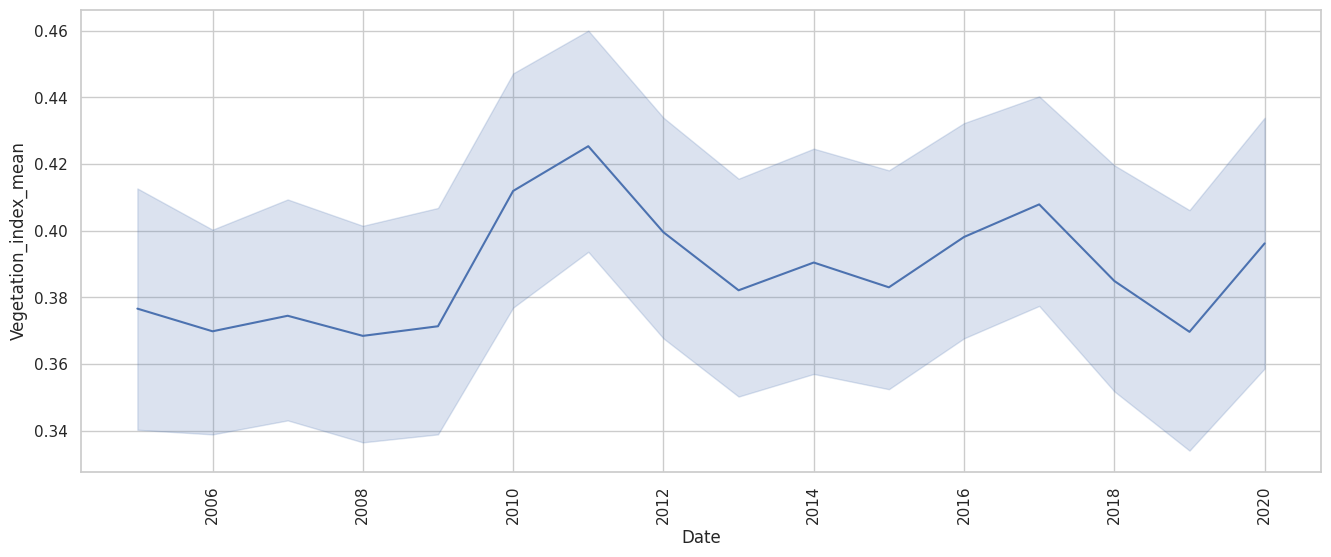

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
plt.xticks(rotation=90)

g = sns.lineplot(x=vegetation_df['Date'].dt.year, y="Vegetation_index_mean",
                 data=vegetation_df)

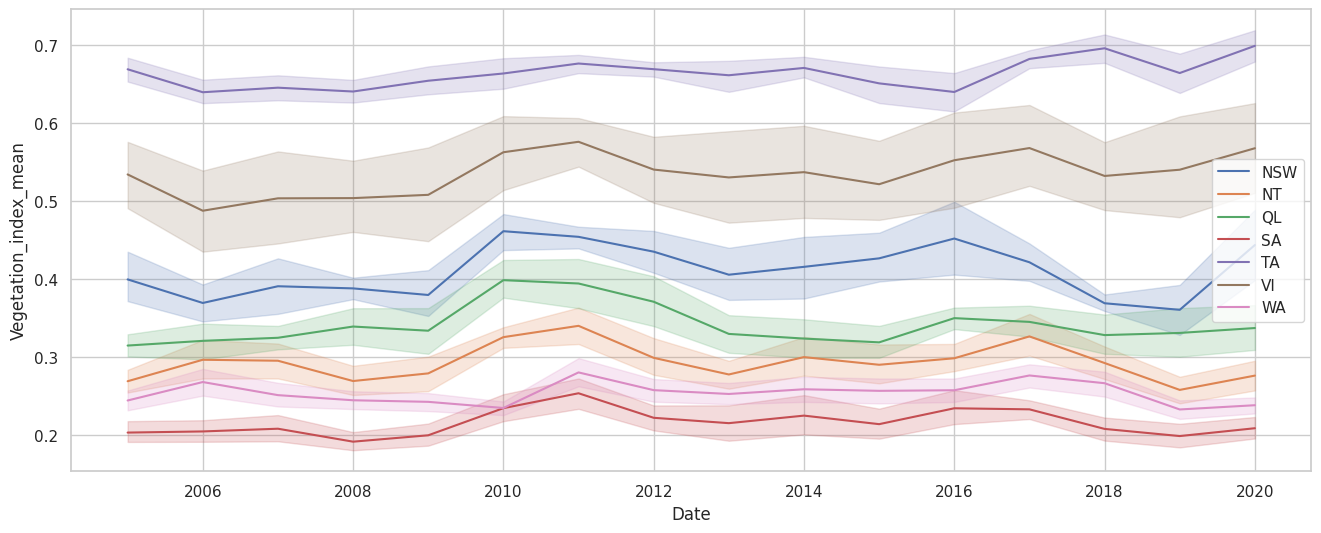

In [ ]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x=vegetation_df['Date'].dt.year, y="Vegetation_index_mean"
    ,hue='Region', data=vegetation_df)
plt.legend(loc='best')

## Temperature Dataset EDA

In [ ]:
temperatures = wget.download('https://raw.githubusercontent.com/PatchiG/Wildfires-Datasets/main/data/misc/NSW_Wildfires_Temperature.csv',
                  'NSW_Wildfires_Temperature.csv')
temperature_df = pd.read_csv(temperatures)
temperature_df.head()

Region_x    Date_x  Estimated_fire_area  Mean_estimated_fire_brightness  \
0      NSW  1/4/2005                26.04                      312.266667   
1      NSW  1/5/2005               132.89                      322.475000   
2      NSW  1/6/2005                16.56                      325.266667   
3      NSW  1/7/2005                31.32                      313.870000   
4      NSW  1/8/2005                16.20                      337.383333   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            42.400000        78.666667        2.886751   
1                            62.362500        85.500000        8.088793   
2                            38.400000        78.333333        3.214550   
3                            33.800000        92.200000        7.529940   
4                           122.533333        91.000000        7.937254   

   Var_confidence  Count Replaced    DateTime      Date_y Region_y  \
0        8.333333      3        R  2005-01-04  2005-01-04      NSW   
1       65.428571      8        R  2005-01-05  2005-01-05      NSW   
2       10.333333      3        R  2005-01-06  2005-01-06      NSW   
3       56.700000      5        R  2005-01-07  2005-01-07      NSW   
4       63.000000      3        R  2005-01-08  2005-01-08      NSW   

     Parameter  count()[unit: km^2]      min()      max()     mean()  \
0  Temperature        800234.348986  12.495799  28.945488  23.055527   
1  Temperature        800234.348986   9.611800  29.510120  22.425765   
2  Temperature        800234.348986   9.024039  26.982698  20.621405   
3  Temperature        800234.348986   8.691216  24.752069  19.632722   
4  Temperature        800234.348986  10.821342  26.472469  21.477315   

   2nd moment  
0  541.012822  
1  516.267308  
2  437.006517  
3  393.384139  
4  473.339043

## LandClass Data EDA


In [ ]:
file_landclass = "Jan_23/LandClass.csv"
print("Reading file: '{}'".format(file_landclass))
land_df = pd.read_csv(file_landclass)

land_df.head()

Reading file: 'Jan_23/LandClass.csv'


Region  Shrubs  Herbaceous vegetation  \
0    NSW     6.2                   43.6   
1     NT    18.1                   48.9   
2     QL     9.5                   45.3   
3     SA    24.1                   54.8   
4     TA     0.7                   23.8   

   Cultivated and managed vegetation/agriculture (cropland)  Urban / built up  \
0                                               13.0                      0.3   
1                                                0.1                      0.0   
2                                                1.6                      0.1   
3                                                5.8                      0.1   
4                                                1.2                      0.2   

   Bare / sparse vegetation  Permanent water bodies  Herbaceous wetland  \
0                       0.2                     0.2                 0.1   
1                       0.4                     0.1                 0.1   
2                       1.1                     0.1                 0.0   
3                       4.8                     1.2                 0.1   
4                       0.1                     1.9                 1.4   

   Closed forest, evergreen, broad leaf  Closed forest, deciduous broad leaf  \
0                                  14.7                                  6.8   
1                                   1.0                                  7.7   
2                                   5.3                                 13.3   
3                                   0.3                                  1.3   
4                                  50.1                                  0.6   

   Closed forest, unknown  Open forest, evergreen broad leaf  \
0                     0.3                                0.5   
1                     0.1                                0.1   
2                     0.3                                0.1   
3                     0.1                                0.1   
4                     1.1                                7.2   

   Open forest, deciduous broad leaf  Open forest, unknown definitions  \
0                                3.7                              10.3   
1                               13.6                               9.3   
2                               12.0                              11.0   
3                                1.4                               5.3   
4                                1.5                               7.2   

   Open sea  
0       0.1  
1       0.5  
2       0.3  
3       0.6  
4       3.0

In [ ]:
land_df.describe()

Shrubs  Herbaceous vegetation  \
count   7.000000               7.000000   
mean   13.042857              42.128571   
std    11.750441              10.060436   
min     0.700000              23.800000   
25%     3.800000              39.250000   
50%     9.500000              43.600000   
75%    21.100000              47.100000   
max    31.300000              54.800000   

       Cultivated and managed vegetation/agriculture (cropland)  \
count                                           7.000000          
mean                                            7.228571          
std                                             8.317995          
min                                             0.100000          
25%                                             1.400000          
50%                                             5.600000          
75%                                             9.400000          
max                                            23.300000          

       Urban / built up  Bare / sparse vegetation  Permanent water bodies  \
count          7.000000                  7.000000                7.000000   
mean           0.242857                  1.100000                0.642857   
std            0.350510                  1.683251                0.675419   
min            0.000000                  0.100000                0.100000   
25%            0.050000                  0.150000                0.150000   
50%            0.100000                  0.400000                0.400000   
75%            0.250000                  1.050000                0.900000   
max            1.000000                  4.800000                1.900000   

       Herbaceous wetland  Closed forest, evergreen, broad leaf  \
count            7.000000                              7.000000   
mean             0.285714                             13.785714   
std              0.501427                             18.246500   
min              0.000000                              0.300000   
25%              0.050000                              1.100000   
50%              0.100000                              5.300000   
75%              0.200000                             19.300000   
max              1.400000                             50.100000   

       Closed forest, deciduous broad leaf  Closed forest, unknown  \
count                             7.000000                7.000000   
mean                              5.128571                0.342857   
std                               4.482453                0.345722   
min                               0.600000                0.100000   
25%                               1.850000                0.150000   
50%                               3.800000                0.300000   
75%                               7.250000                0.300000   
max                              13.300000                1.100000   

       Open forest, evergreen broad leaf  Open forest, deciduous broad leaf  \
count                           7.000000                           7.000000   
mean                            1.371429                           5.671429   
std                             2.620887                           5.033791   
min                             0.100000                           1.400000   
25%                             0.100000                           2.100000   
50%                             0.100000                           3.700000   
75%                             1.000000                           8.400000   
max                             7.200000                          13.600000   

       Open forest, unknown definitions  Open sea  
count                          7.000000  7.000000  
mean                           8.142857  0.885714  
std                            2.312904  0.971989  
min                            5.200000  0.100000  
25%                            6.250000  0.400000  
50%                            8.700000  0.600000  
75%          

In [ ]:
df_land_class = land_df.sort_values(by='Region').T.copy()
df_land_class.rename(columns=df_land_class.iloc[0], inplace=True)
df_land_class.drop(['Region'], axis=0, inplace=True)
df_land_class = df_land_class.astype(float)
df_land_class = df_land_class.rename_axis('Land Type').reset_index()
df_land_class

Land Type   NSW    NT    QL    SA  \
0                                              Shrubs   6.2  18.1   9.5  24.1   
1                               Herbaceous vegetation  43.6  48.9  45.3  54.8   
2   Cultivated and managed vegetation/agriculture ...  13.0   0.1   1.6   5.8   
3                                    Urban / built up   0.3   0.0   0.1   0.1   
4                            Bare / sparse vegetation   0.2   0.4   1.1   4.8   
5                              Permanent water bodies   0.2   0.1   0.1   1.2   
6                                  Herbaceous wetland   0.1   0.1   0.0   0.1   
7                Closed forest, evergreen, broad leaf  14.7   1.0   5.3   0.3   
8                 Closed forest, deciduous broad leaf   6.8   7.7  13.3   1.3   
9                              Closed forest, unknown   0.3   0.1   0.3   0.1   
10                  Open forest, evergreen broad leaf   0.5   0.1   0.1   0.1   
11                  Open forest, deciduous broad leaf   3.7  13.6  12.0   1.4   
12                   Open forest, unknown definitions  10.3   9.3  11.0   5.3   
13                                           Open sea   0.1   0.5   0.3   0.6   

      TA    VI    WA  
0    0.7   1.4  31.3  
1   23.8  35.0  43.5  
2    1.2  23.3   5.6  
3    0.2   1.0   0.0  
4    0.1   0.1   1.0  
5    1.9   0.6   0.4  
6    1.4   0.3   0.0  
7   50.1  23.9   1.2  
8    0.6   3.8   2.4  
9    1.1   0.3   0.2  
10   7.2   1.5   0.1  
11   1.5   2.7   4.8  
12   7.2   5.2   8.7  
13   3.0   0.9   0.8

## Overall Data Exploration

In [ ]:
# merge historical fire and weather data into one DataFrame
df_all = wildfire_df.merge(weather_data, how='left', on=['Date', 'Region'])
df_all.head()

Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
0    NSW 2005-01-04              8.68000                      312.266667   
1    NSW 2005-01-05             16.61125                      322.475000   
2    NSW 2005-01-06              5.52000                      325.266667   
3    NSW 2005-01-07              6.26400                      313.870000   
4    NSW 2005-01-08              5.40000                      337.383333   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            42.400000        78.666667        2.886751   
1                            62.362500        85.500000        8.088793   
2                            38.400000        78.333333        3.214550   
3                            33.800000        92.200000        7.529940   
4                           122.533333        91.000000        7.937254   

   Var_confidence  Count Replaced  ...  SolarRadiation_mean  \
0        8.333333      3        R  ...            22.617291   
1       65.428571      8        R  ...            28.076835   
2       10.333333      3        R  ...            30.561703   
3       56.700000      5        R  ...            32.143718   
4       63.000000      3        R  ...            29.347715   

   SolarRadiation_min  Temperature_2nd_moment  Temperature_max  \
0            7.576938                9.455474        28.945488   
1           14.087289               13.352380        29.510120   
2           12.310518               11.764178        26.982698   
3           16.044561                7.940373        24.752069   
4           15.209880               12.063971        26.472469   

   Temperature_mean  Temperature_min  WindSpeed_2nd_moment  WindSpeed_max  \
0         23.055527        12.495799              1.494301       7.364222   
1         22.425765         9.611800              1.043316       7.091141   
2         20.621405         9.024039              1.953685       9.905821   
3         19.632722         8.691216              1.102751      10.446799   
4         21.477315        10.821342              0.774612       6.671862   

   WindSpeed_mean  WindSpeed_min  
0        4.841764       1.401951  
1        4.014080       1.011328  
2        4.477879       0.930842  
3        4.017578       1.601724  
4        3.884550       1.167861  

[5 rows x 35 columns]

In [ ]:
df_all.describe()

Date  Estimated_fire_area  \
count                          26719         26719.000000   
mean   2013-01-22 07:29:51.309554944           143.634199   
min              2005-01-01 00:00:00             1.000000   
25%              2009-01-13 00:00:00             8.815000   
50%              2013-02-01 00:00:00            38.143636   
75%              2017-03-12 00:00:00           146.277390   
max              2021-01-22 00:00:00         10120.943170   
std                              NaN           313.203078   

       Mean_estimated_fire_brightness  Mean_estimated_fire_radiative_power  \
count                    26719.000000                         26719.000000   
mean                       319.708244                            83.660705   
min                        290.700000                             0.000000   
25%                        313.952652                            44.102803   
50%                        319.834524                            67.100000   
75%                        325.467990                           103.148413   
max                        381.950000                          2178.600000   
std                          8.895219                            67.793807   

       Mean_confidence  Std_confidence  Var_confidence         Count  \
count     26719.000000    26719.000000    26719.000000  26719.000000   
mean         87.579075        6.619987       51.507215     71.754968   
min          76.000000        0.000000        0.000000      1.000000   
25%          85.000000        6.037124       36.446861      5.000000   
50%          87.777778        7.590293       57.612555     20.000000   
75%          90.500000        8.185777       67.006953     74.000000   
max         100.000000       16.970563      288.000000   3954.000000   
std           4.376509        2.771871       29.319157    150.437873   

               area  Precipitation_2nd_moment  ...  SolarRadiation_mean  \
count  2.668800e+04              26688.000000  ...         26688.000000   
mean   1.399896e+06                 13.971640  ...            20.437946   
min    6.778526e+04                  0.000000  ...             0.000000   
25%    8.002343e+05                  0.019139  ...            15.867635   
50%    1.357561e+06                  0.353744  ...            20.748898   
75%    1.730605e+06                  4.798790  ...            25.382519   
max    2.528546e+06               1580.491577  ...            33.814362   
std    7.599821e+05                 56.336164  ...             6.034787   

       SolarRadiation_min  Temperature_2nd_moment  Temperature_max  \
count        26688.000000            26688.000000     26688.000000   
mean            11.272581               12.161123        28.040867   
min              0.000000                0.000000         0.000000   
25%              6.485264                5.431296        24.544297   
50%             10.602321                9.812242        28.739205   
75%             15.440889               16.470561        33.483602   
max             32.148338               65.176108        41.738968   
std              5.904823                8.961685         6.785193   

       Temperature_mean  Temperature_min  WindSpeed_2nd_moment  WindSpeed_max  \
count      26688.000000     26688.000000          26688.000000   26688.000000   
mean          21.386695        13.237066              1.238689       8.480026   
min            0.000000        -5.055067              0.000000       0.000000   
25%           16.320205         8.983616              0.668502       6.945163   
50%           21.726346        13.063880              1.019431       8.330623   
75%           27.040333        17.352069              1.564924       9.867392   
max           38.130627        29.563280              9.087087      24.274473   
std            6.637532         6.113054              0.823489       2.138832   

       WindSpeed_mean  WindSpeed_min  
count    26688.000000   26688.000000  
mean         3.

In [ ]:
wildfire_weather_data = df_all

In [ ]:
# Number of records
num_rows, num_cols = wildfire_weather_data.shape
print("Total Records:\t{}".format(num_rows))

wildfire_weather_data.head()

Total Records:	26719


Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
0    NSW 2005-01-04              8.68000                      312.266667   
1    NSW 2005-01-05             16.61125                      322.475000   
2    NSW 2005-01-06              5.52000                      325.266667   
3    NSW 2005-01-07              6.26400                      313.870000   
4    NSW 2005-01-08              5.40000                      337.383333   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            42.400000        78.666667        2.886751   
1                            62.362500        85.500000        8.088793   
2                            38.400000        78.333333        3.214550   
3                            33.800000        92.200000        7.529940   
4                           122.533333        91.000000        7.937254   

   Var_confidence  Count Replaced  ...  SolarRadiation_mean  \
0        8.333333      3        R  ...            22.617291   
1       65.428571      8        R  ...            28.076835   
2       10.333333      3        R  ...            30.561703   
3       56.700000      5        R  ...            32.143718   
4       63.000000      3        R  ...            29.347715   

   SolarRadiation_min  Temperature_2nd_moment  Temperature_max  \
0            7.576938                9.455474        28.945488   
1           14.087289               13.352380        29.510120   
2           12.310518               11.764178        26.982698   
3           16.044561                7.940373        24.752069   
4           15.209880               12.063971        26.472469   

   Temperature_mean  Temperature_min  WindSpeed_2nd_moment  WindSpeed_max  \
0         23.055527        12.495799              1.494301       7.364222   
1         22.425765         9.611800              1.043316       7.091141   
2         20.621405         9.024039              1.953685       9.905821   
3         19.632722         8.691216              1.102751      10.446799   
4         21.477315        10.821342              0.774612       6.671862   

   WindSpeed_mean  WindSpeed_min  
0        4.841764       1.401951  
1        4.014080       1.011328  
2        4.477879       0.930842  
3        4.017578       1.601724  
4        3.884550       1.167861  

[5 rows x 35 columns]

## Data Distributions

<Figure size 1200x1200 with 0 Axes>

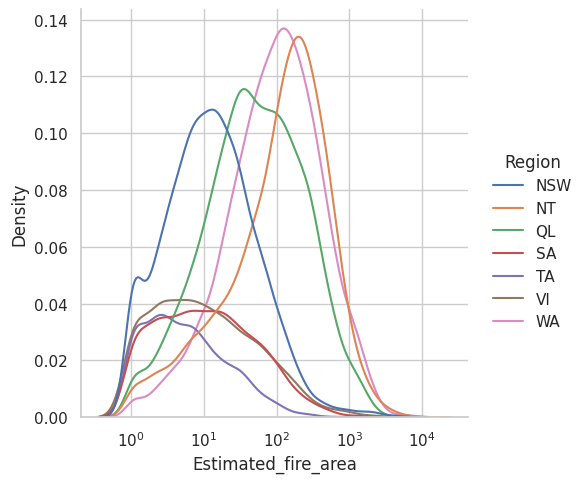

In [ ]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
#g = sns.displot(data=df_all, x="Estimated_fire_area", hue="Region", kind="kde");
g = sns.displot(data=df_all, x="Estimated_fire_area", hue="Region", kind="kde", log_scale=True)

<Figure size 1200x1200 with 0 Axes>

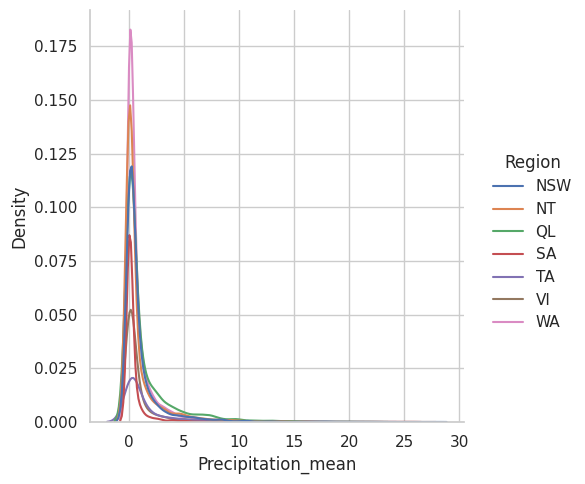

In [ ]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
g = sns.displot(data=df_all, x="Precipitation_mean", hue="Region", kind="kde")

<Figure size 1200x1200 with 0 Axes>

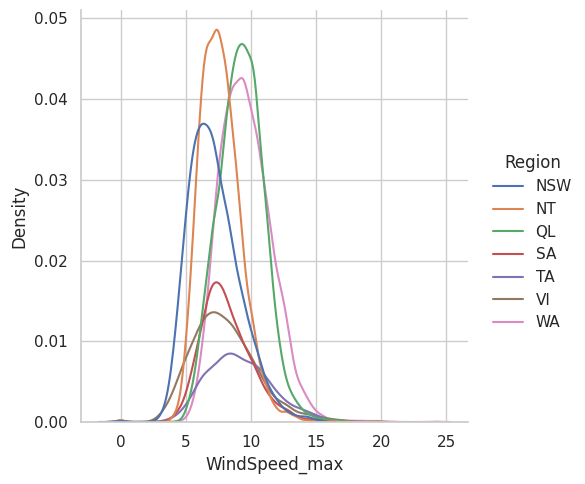

In [ ]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
g = sns.displot(data=df_all, x="WindSpeed_max", hue="Region", kind="kde")

<Figure size 1200x1200 with 0 Axes>

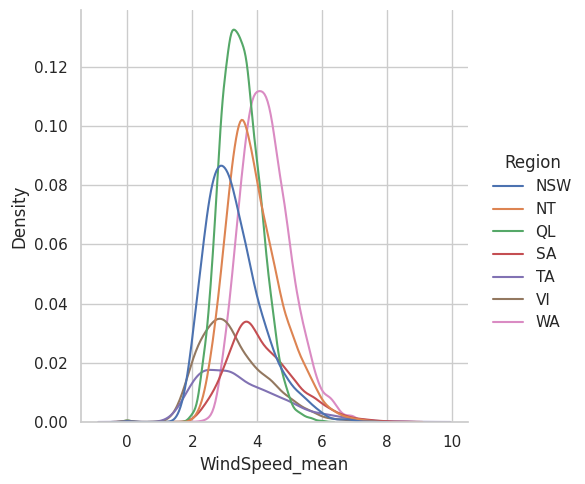

In [ ]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
g = sns.displot(data=df_all, x="WindSpeed_mean", hue="Region", kind="kde")

## Correlations

<Axes: >

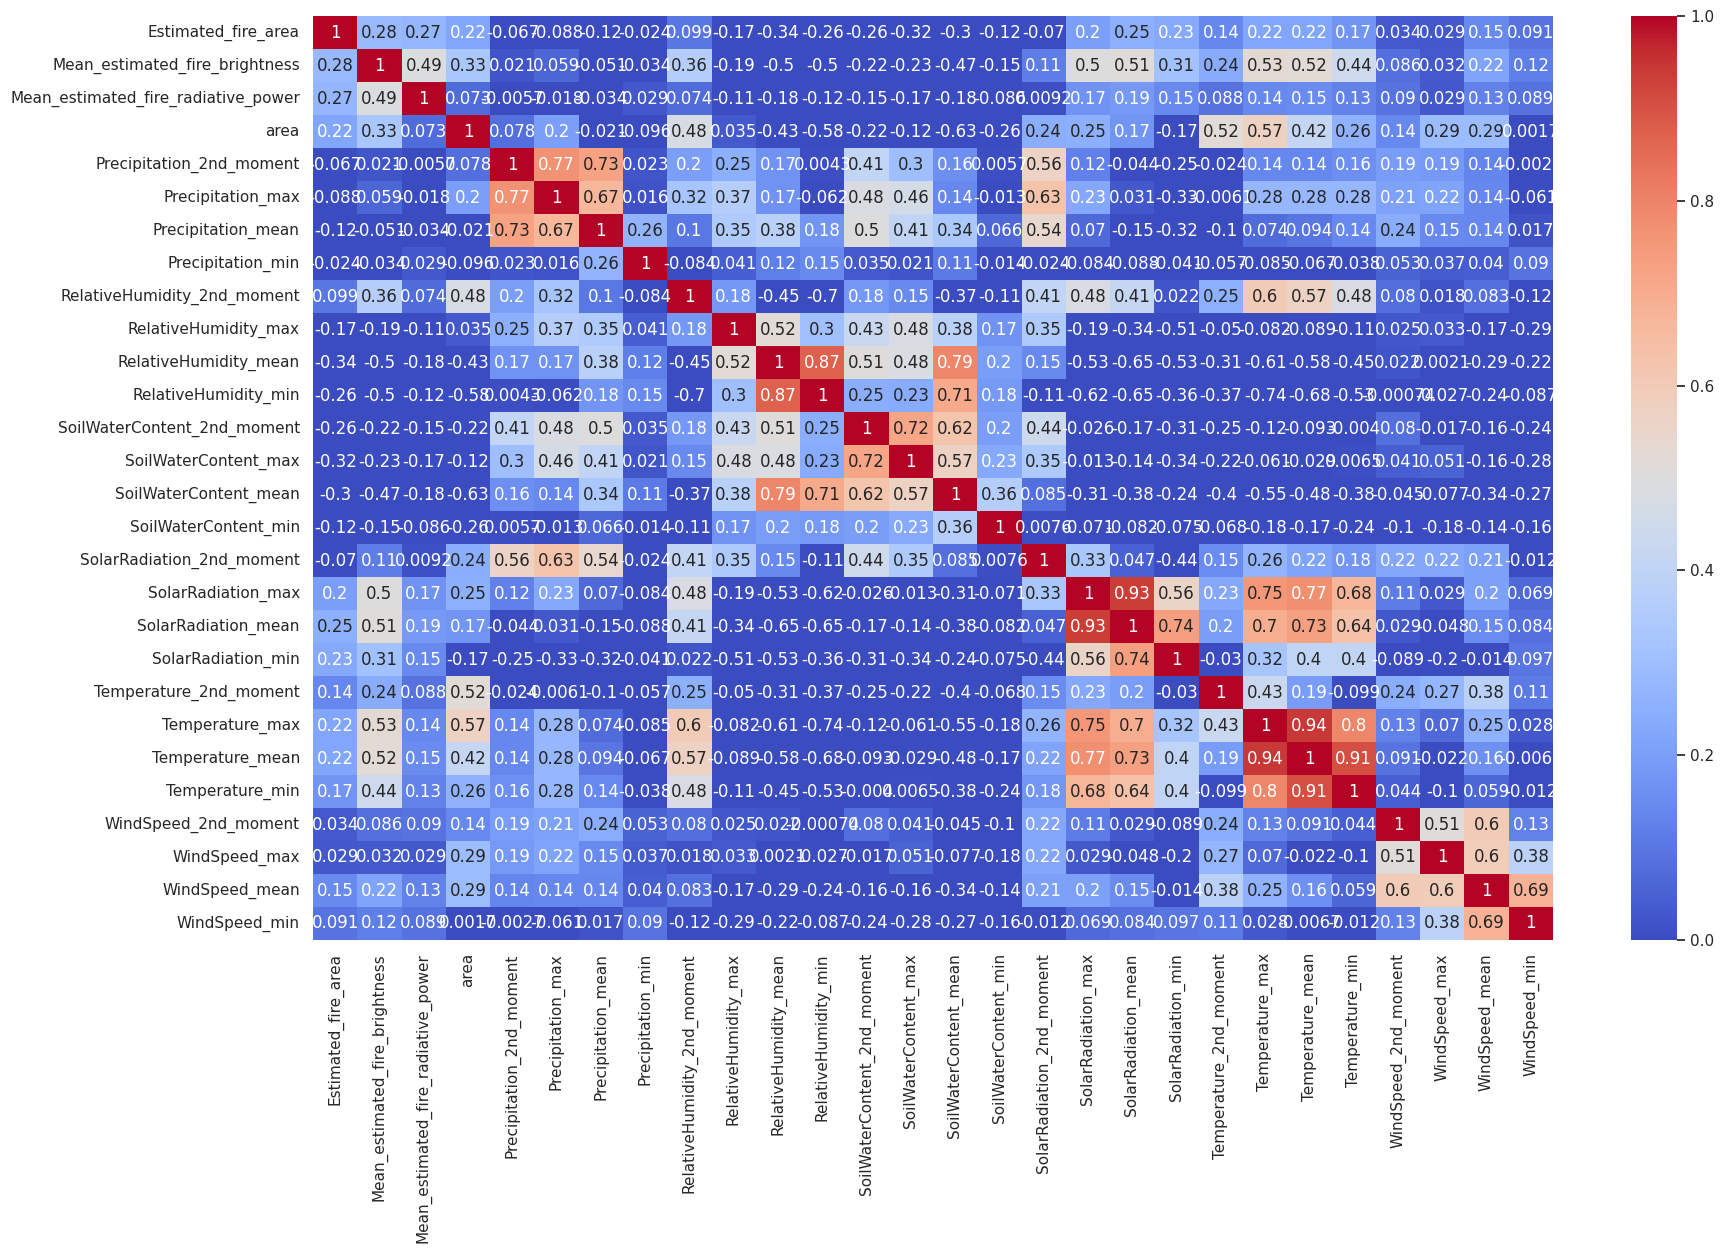

In [ ]:
df_corr = df_all.drop(['Region', 'Date', 'Mean_confidence', 'Std_confidence', 'Var_confidence',
                            'Count', 'Replaced'], axis=1).copy()

plt.figure(figsize = (20, 12))
sns.heatmap(df_corr.corr(), cmap = "coolwarm", annot= True, vmin = 0, vmax = 1)

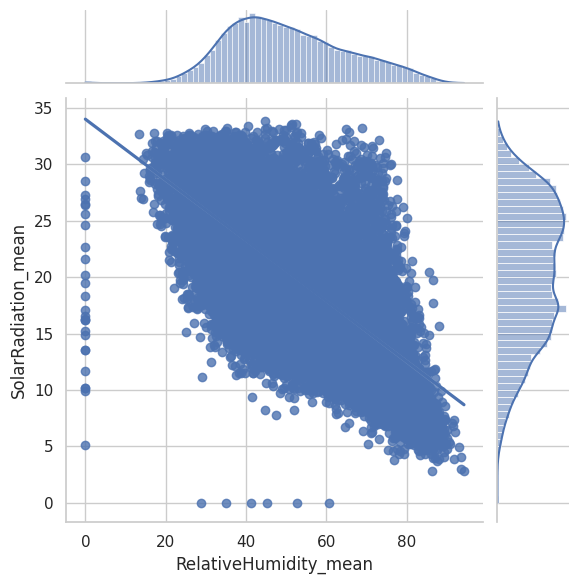

In [ ]:
sns.jointplot(x='RelativeHumidity_mean', y='SolarRadiation_mean', data=df_all, kind="reg")


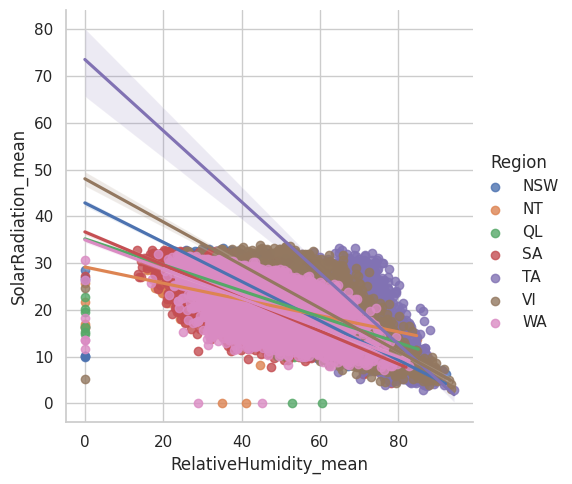

In [ ]:
sns.lmplot(x='RelativeHumidity_mean', y='SolarRadiation_mean', hue='Region', data=df_all);


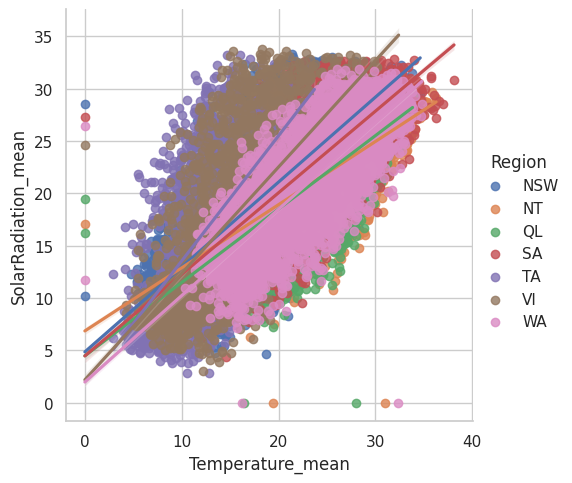

In [ ]:
sns.lmplot(x='Temperature_mean', y='SolarRadiation_mean', hue='Region', data=df_all);


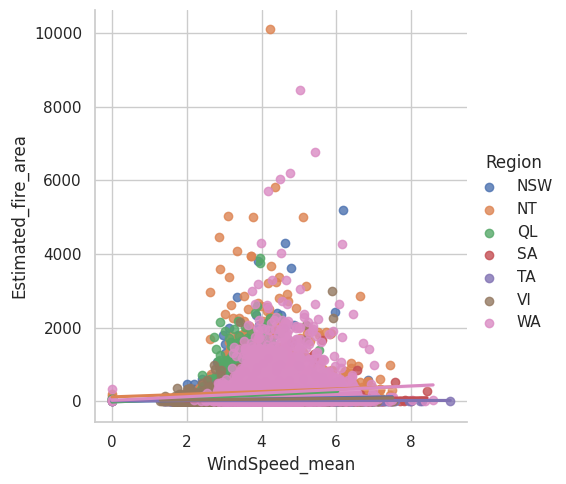

In [ ]:
sns.lmplot(x='WindSpeed_mean', y='Estimated_fire_area', hue='Region', data=df_all);


# Wildfire Weather with Weather Forecasts Data

In [ ]:
fires_weather_forcasts = wildfire_weather_data.merge(weather_forcasts_data, how='left', on=['Date', 'Region'])

# Number of records
num_rows, num_cols = fires_weather_forcasts.shape
print("Total Records:\t{}".format(num_rows))

fires_weather_forcasts.head()


Total Records:	45352


Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
0    NSW 2005-01-04              8.68000                      312.266667   
1    NSW 2005-01-05             16.61125                      322.475000   
2    NSW 2005-01-06              5.52000                      325.266667   
3    NSW 2005-01-07              6.26400                      313.870000   
4    NSW 2005-01-08              5.40000                      337.383333   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            42.400000        78.666667        2.886751   
1                            62.362500        85.500000        8.088793   
2                            38.400000        78.333333        3.214550   
3                            33.800000        92.200000        7.529940   
4                           122.533333        91.000000        7.937254   

   Var_confidence  Count Replaced  ...  SolarRadiation_mean_forcast  \
0        8.333333      3        R  ...                          NaN   
1       65.428571      8        R  ...                          NaN   
2       10.333333      3        R  ...                          NaN   
3       56.700000      5        R  ...                          NaN   
4       63.000000      3        R  ...                          NaN   

   SolarRadiation_min_forcast  Temperature_2nd_moment_forcast  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   Temperature_max_forcast  Temperature_mean_forcast  Temperature_min_forcast  \
0                      NaN                       NaN                      NaN   
1                      NaN                       NaN                      NaN   
2                      NaN                       NaN                      NaN   
3                      NaN                       NaN                      NaN   
4                      NaN                       NaN                      NaN   

   WindSpeed_2nd_moment_forcast  WindSpeed_max_forcast  \
0                           NaN                    NaN   
1                           NaN                    NaN   
2                           NaN                    NaN   
3                           NaN                    NaN   
4                           NaN                    NaN   

   WindSpeed_mean_forcast  WindSpeed_min_forcast  
0                     NaN                    NaN  
1                     NaN                    NaN  
2                     NaN                    NaN  
3                     NaN                    NaN  
4                     NaN                    NaN  

[5 rows x 57 columns]

Wildfires with Weather data has around ~27K data whereas when combine with Weather Forcasts data, it results in 45K records because Weather Forcasts data contains Lead Time values of 5, 10 and 15 on basis of some dates and region

Since, Historical Weather Forecasts data starts from 2014-01-01. So, let's filter above data accordingly.

In [ ]:
analysis_df = fires_weather_forcasts.loc[fires_weather_forcasts['Date'] >= forecasts_df['Date'].min(), :].copy()
analysis_df.reset_index(drop=True, inplace=True)
analysis_df.sort_values(by=['Region', 'Date'], inplace=True)

num_rows, num_cols = analysis_df.shape
print("There are total {} records.".format(num_rows))
analysis_df.head()

There are total 30448 records.


Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
0    NSW 2014-01-01             3.000000                      321.216667   
1    NSW 2014-01-03            74.017209                      320.410465   
2    NSW 2014-01-04           102.937500                      318.631250   
3    NSW 2014-01-05            85.902143                      322.239286   
4    NSW 2014-01-06           145.659508                      319.965574   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            49.966667        91.000000        9.000000   
1                            70.576744        93.720930        7.935231   
2                           119.006250        88.750000        7.812315   
3                            63.289286        91.910714        8.334543   
4                           108.895082        91.426230        7.497686   

   Var_confidence  Count Replaced  ...  SolarRadiation_mean_forcast  \
0       81.000000      3        R  ...                    31.647308   
1       62.967885     43        R  ...                    24.660504   
2       61.032258     32        R  ...                    32.975682   
3       69.464610     56        R  ...                    32.435075   
4       56.215301     61        R  ...                    33.590963   

   SolarRadiation_min_forcast  Temperature_2nd_moment_forcast  \
0                   24.865765                       17.918553   
1                   11.779593                       16.553366   
2                   20.678528                       13.024237   
3                    8.228070                       10.446423   
4                   21.573400                       12.428537   

   Temperature_max_forcast  Temperature_mean_forcast  Temperature_min_forcast  \
0                36.929035                 30.893523                21.243755   
1                36.304554                 28.740031                15.639575   
2                32.729553                 23.613320                11.868508   
3                29.856218                 22.985766                12.450391   
4                29.237406                 20.960910                 9.444987   

   WindSpeed_2nd_moment_forcast  WindSpeed_max_forcast  \
0                      1.334834               6.989559   
1                      6.354403              10.795617   
2                      1.689959               8.223342   
3                      2.615668               7.229513   
4                      3.398943               8.868293   

   WindSpeed_mean_forcast  WindSpeed_min_forcast  
0                3.958822               1.593531  
1                5.696997               1.511390  
2                4.260682               1.277267  
3                3.967104               1.000668  
4                4.961131               1.604553  

[5 rows x 57 columns]

In [ ]:
analysis_df.loc[analysis_df['Lead time'].isna(), :]

Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
37       NSW 2014-02-11            11.128571                      328.592857   
83       NSW 2014-04-15           133.031250                      310.690625   
84       NSW 2014-04-16            49.102083                      314.197917   
85       NSW 2014-04-17           129.200000                      309.731818   
86       NSW 2014-04-18            17.256667                      318.290000   
...      ...        ...                  ...                             ...   
24306     WA 2014-12-25            39.414286                      330.464286   
24332     WA 2015-01-20            83.706333                      323.451667   
24333     WA 2015-01-21            59.351163                      318.481395   
24334     WA 2015-01-22           188.022857                      332.320635   
24458     WA 2015-05-27            76.048000                      324.180000   

       Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
37                               57.742857        88.142857        8.474050   
83                              128.181250        85.406250        6.964701   
84                               36.979167        85.583333        5.978092   
85                              149.795455        83.409091        6.238583   
86                               59.960000        85.066667        8.101734   
...                                    ...              ...             ...   
24306                            82.335714        88.035714        8.987572   
24332                           110.653333        90.566667        8.323972   
24333                            45.341860        94.255814        8.403778   
24334                           156.650794        93.095238        7.600327   
24458                            42.030769        87.015385        7.186124   

       Var_confidence  Count Replaced  ...  SolarRadiation_mean_forcast  \
37          71.809524      7        R  ...                          NaN   
83          48.507056     32        R  ...                          NaN   
84          35.737589     48        R  ...                          NaN   
85          38.919913     22        R  ...                          NaN   
86          65.638095     15        R  ...                          NaN   
...               ...    ...      ...  ...                          ...   
24306       80.776455     28        R  ...                          NaN   
24332       69.288506     30        R  ...                          NaN   
24333       70.623477     43        R  ...                          NaN   
24334       57.764977     63        R  ...                          NaN   
24458       51.640385     65        R  ...                          NaN   

       SolarRadiation_min_forcast  Temperature_2nd_moment_forcast  \
37                            NaN                             NaN   
83                            NaN                             NaN   
84                            NaN                             NaN   
85                            NaN                             NaN   
86                            NaN                             NaN   
...                           ...                             ...   
24306                         NaN                             NaN   
24332                         NaN                             NaN   
24333                         NaN                             NaN   
24334                         NaN                             NaN   
24458                         NaN                             NaN   

       Temperature_max_forcast  Temperature_mean_forcast  \
37                         NaN                       NaN   
83                         NaN                       NaN   
84                         NaN                       NaN   
85                         NaN                       NaN   
86                         NaN                       NaN   
...   

In [ ]:
analysis_df = analysis_df.fillna(0).copy()
analysis_df.head()

Region       Date  Estimated_fire_area  Mean_estimated_fire_brightness  \
0    NSW 2014-01-01             3.000000                      321.216667   
1    NSW 2014-01-03            74.017209                      320.410465   
2    NSW 2014-01-04           102.937500                      318.631250   
3    NSW 2014-01-05            85.902143                      322.239286   
4    NSW 2014-01-06           145.659508                      319.965574   

   Mean_estimated_fire_radiative_power  Mean_confidence  Std_confidence  \
0                            49.966667        91.000000        9.000000   
1                            70.576744        93.720930        7.935231   
2                           119.006250        88.750000        7.812315   
3                            63.289286        91.910714        8.334543   
4                           108.895082        91.426230        7.497686   

   Var_confidence  Count Replaced  ...  SolarRadiation_mean_forcast  \
0       81.000000      3        R  ...                    31.647308   
1       62.967885     43        R  ...                    24.660504   
2       61.032258     32        R  ...                    32.975682   
3       69.464610     56        R  ...                    32.435075   
4       56.215301     61        R  ...                    33.590963   

   SolarRadiation_min_forcast  Temperature_2nd_moment_forcast  \
0                   24.865765                       17.918553   
1                   11.779593                       16.553366   
2                   20.678528                       13.024237   
3                    8.228070                       10.446423   
4                   21.573400                       12.428537   

   Temperature_max_forcast  Temperature_mean_forcast  Temperature_min_forcast  \
0                36.929035                 30.893523                21.243755   
1                36.304554                 28.740031                15.639575   
2                32.729553                 23.613320                11.868508   
3                29.856218                 22.985766                12.450391   
4                29.237406                 20.960910                 9.444987   

   WindSpeed_2nd_moment_forcast  WindSpeed_max_forcast  \
0                      1.334834               6.989559   
1                      6.354403              10.795617   
2                      1.689959               8.223342   
3                      2.615668               7.229513   
4                      3.398943               8.868293   

   WindSpeed_mean_forcast  WindSpeed_min_forcast  
0                3.958822               1.593531  
1                5.696997               1.511390  
2                4.260682               1.277267  
3                3.967104               1.000668  
4                4.961131               1.604553  

[5 rows x 57 columns]

In [ ]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30448 entries, 0 to 30447
Data columns (total 57 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Region                               30448 non-null  object        
 1   Date                                 30448 non-null  datetime64[ns]
 2   Estimated_fire_area                  30448 non-null  float64       
 3   Mean_estimated_fire_brightness       30448 non-null  float64       
 4   Mean_estimated_fire_radiative_power  30448 non-null  float64       
 5   Mean_confidence                      30448 non-null  float64       
 6   Std_confidence                       30448 non-null  float64       
 7   Var_confidence                       30448 non-null  float64       
 8   Count                                30448 non-null  int64         
 9   Replaced                             30448 non-null  object        
 10  area_x    

In [ ]:
# Remove Duplicates
analysis_df.drop_duplicates(inplace=True)
# Reset dataframe index
analysis_df.reset_index(drop=True, inplace=True)

# counts of data
num_rows, num_cols = analysis_df.shape
print("Total Records:\t{}".format(num_rows))

Total Records:	30448


**Average Estimated Fire Area by each Year**

<ipython-input-81-aa583ba80da9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(x="year", y="Estimated_fire_area", data=fire_year, palette=colors)
<ipython-input-81-aa583ba80da9>:12: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  fig = sns.barplot(x="year", y="Estimated_fire_area", data=fire_year, palette=colors)


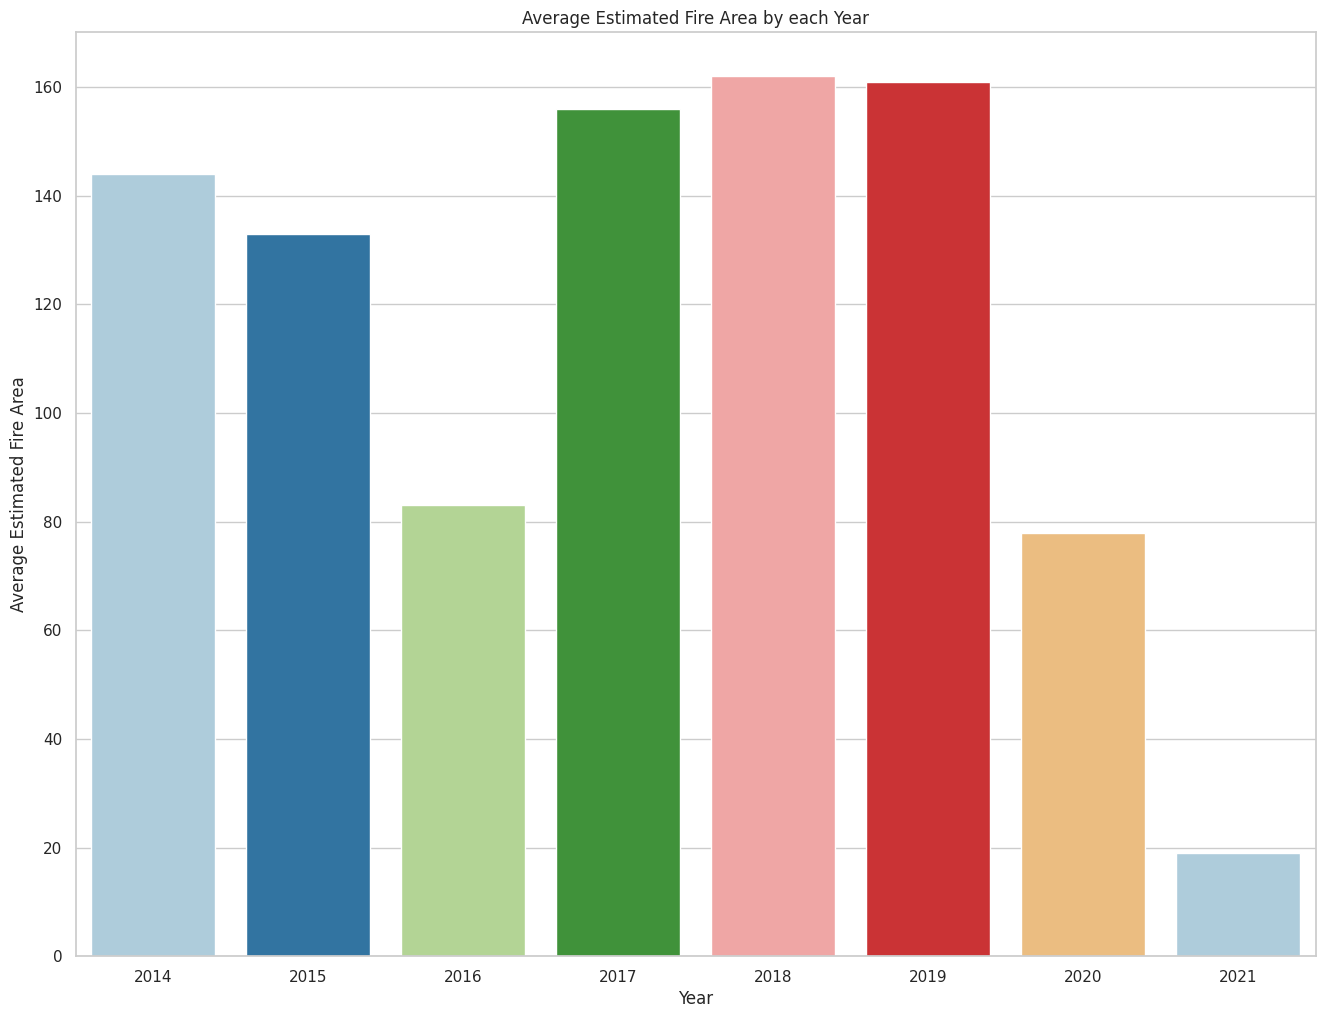

In [ ]:
# Estimated Fire in Dates, Region Analysis
fire_areas = analysis_df[['Region', 'Date', 'Estimated_fire_area']].copy()
fire_areas = fire_areas.drop_duplicates().sort_values(by=['Date']).reset_index(drop=True)
fire_areas['year'] = fire_areas['Date'].dt.year
fire_areas['month'] = fire_areas['Date'].dt.month

fire_year = fire_areas.groupby('year')[['Estimated_fire_area']].mean().round().reset_index()

plt.figure(figsize=(16, 12))
colors = sns.color_palette("Paired", 7)

fig = sns.barplot(x="year", y="Estimated_fire_area", data=fire_year, palette=colors)
fig.set_title('Average Estimated Fire Area by each Year')
fig.set(xlabel='Year', ylabel='Average Estimated Fire Area')
plt.show()

**Average Estimate Fire Area by Year in different Regions**

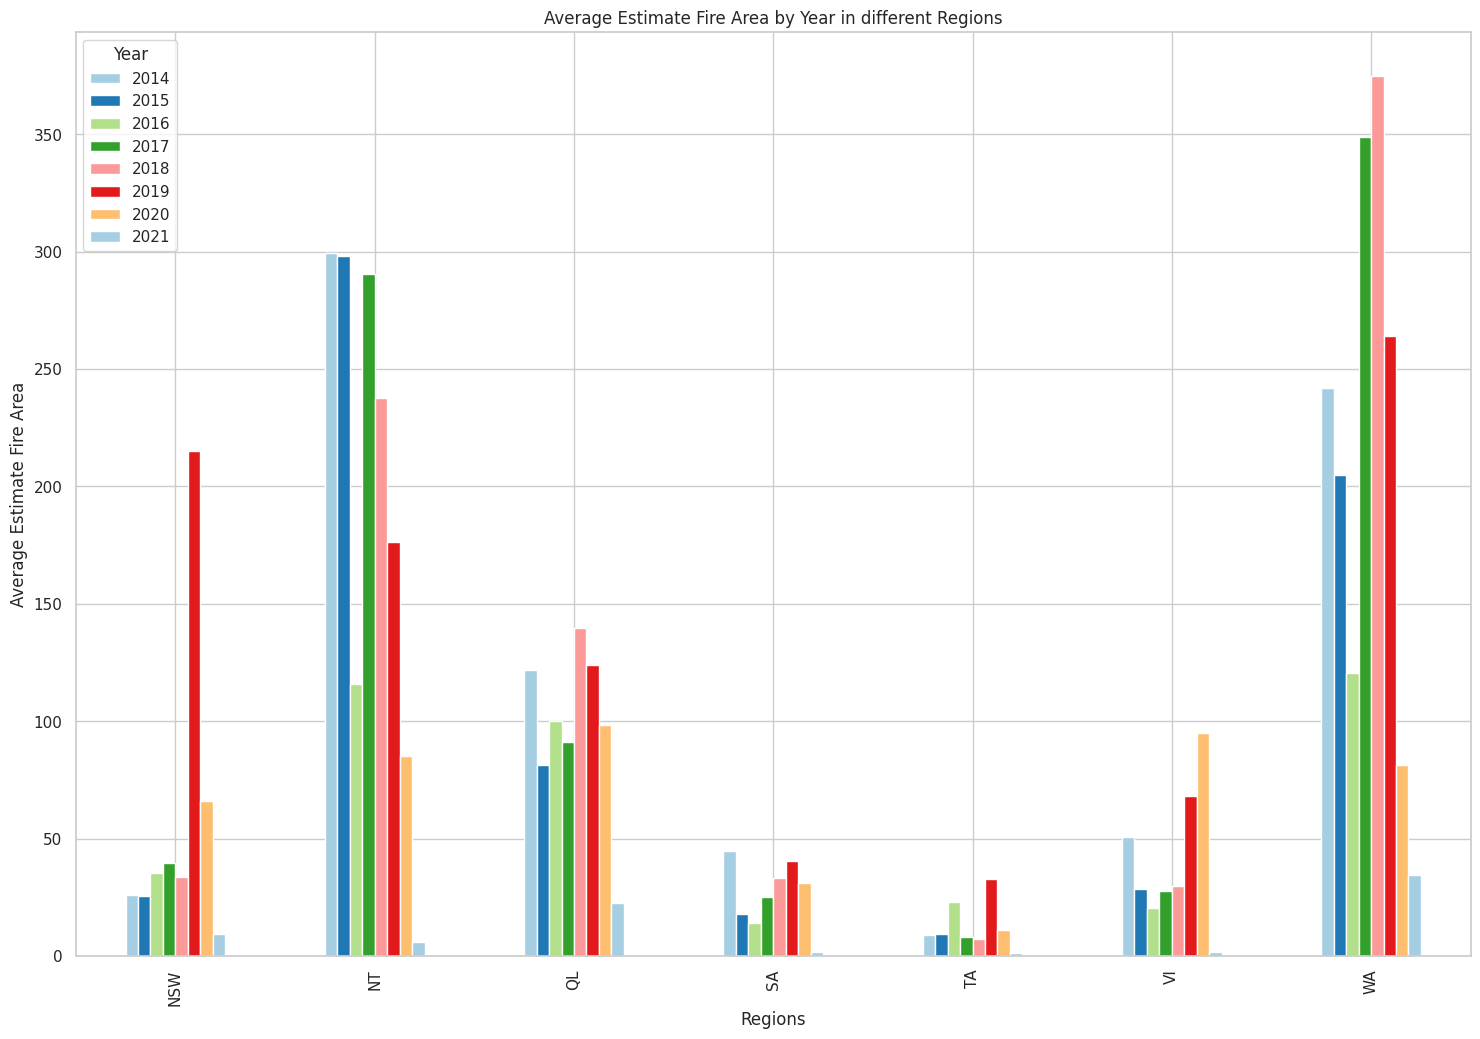

In [ ]:
month_wise = fire_areas.copy()
month_wise['month'] = month_wise['Date'].dt.strftime('%Y %m')
month_wise = month_wise.sort_values(by=['Region', 'Date']).reset_index(drop=True)
month_wise = month_wise.groupby(['Region', 'year'])[['Estimated_fire_area']].mean().reset_index()
month_wise = month_wise.pivot(index='Region', columns='year', values='Estimated_fire_area').fillna(0).reset_index()
month_wise.set_index('Region', inplace=True)

# month_wise.plot(kind="bar", stacked=True, figsize=(16,14)).legend(loc='upper left', title="Regions")
colors = sns.color_palette("Paired", 7)
month_wise.plot(kind="bar", figsize=(18, 12), color=colors).legend(loc='upper left', title="Year")
plt.title("Average Estimate Fire Area by Year in different Regions")
plt.xlabel("Regions")
plt.ylabel("Average Estimate Fire Area")
plt.show()

**Average Estimated Fire Area each Month by Year**

<ipython-input-83-4426952dcc68>:17: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  fig = sns.lineplot(x="month", y="Mean_estimated_fire_brightness", hue="year", data=f_bright, linewidth=3, palette=colors)
<ipython-input-83-4426952dcc68>:29: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  fig = sns.lineplot(x="month", y="Mean_estimated_fire_radiative_power", hue="year", data=f_power, linewidth=3, palette=colors)


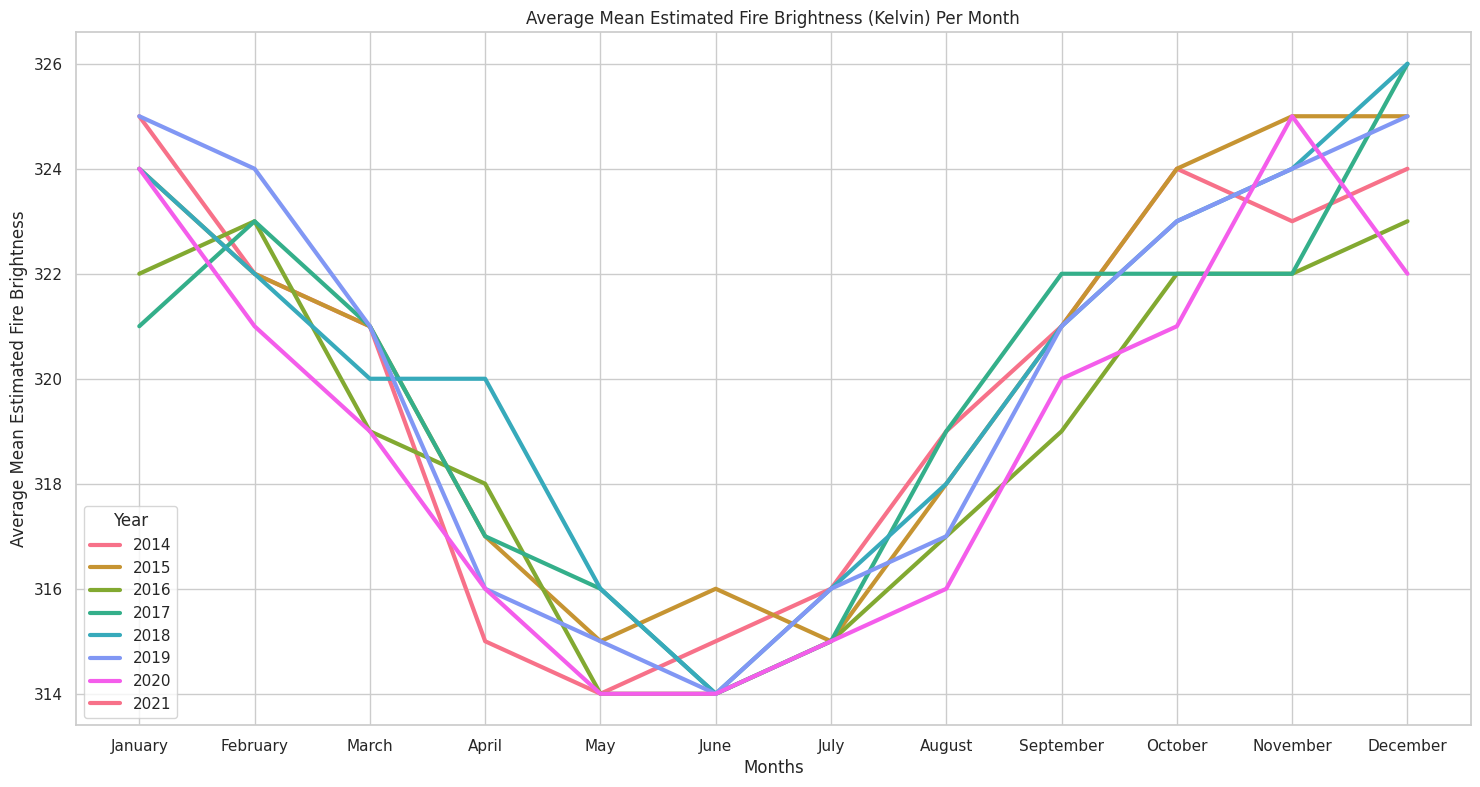

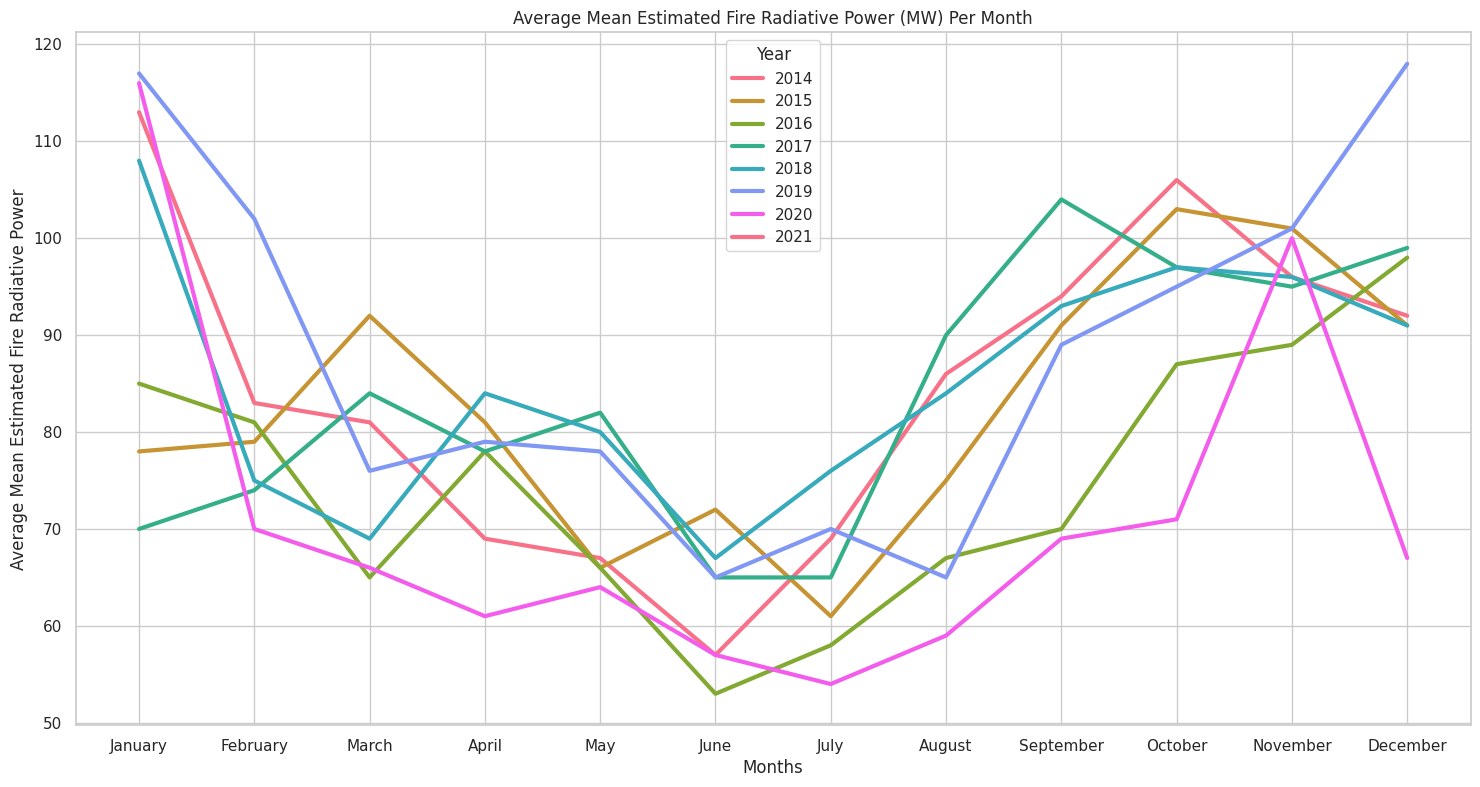

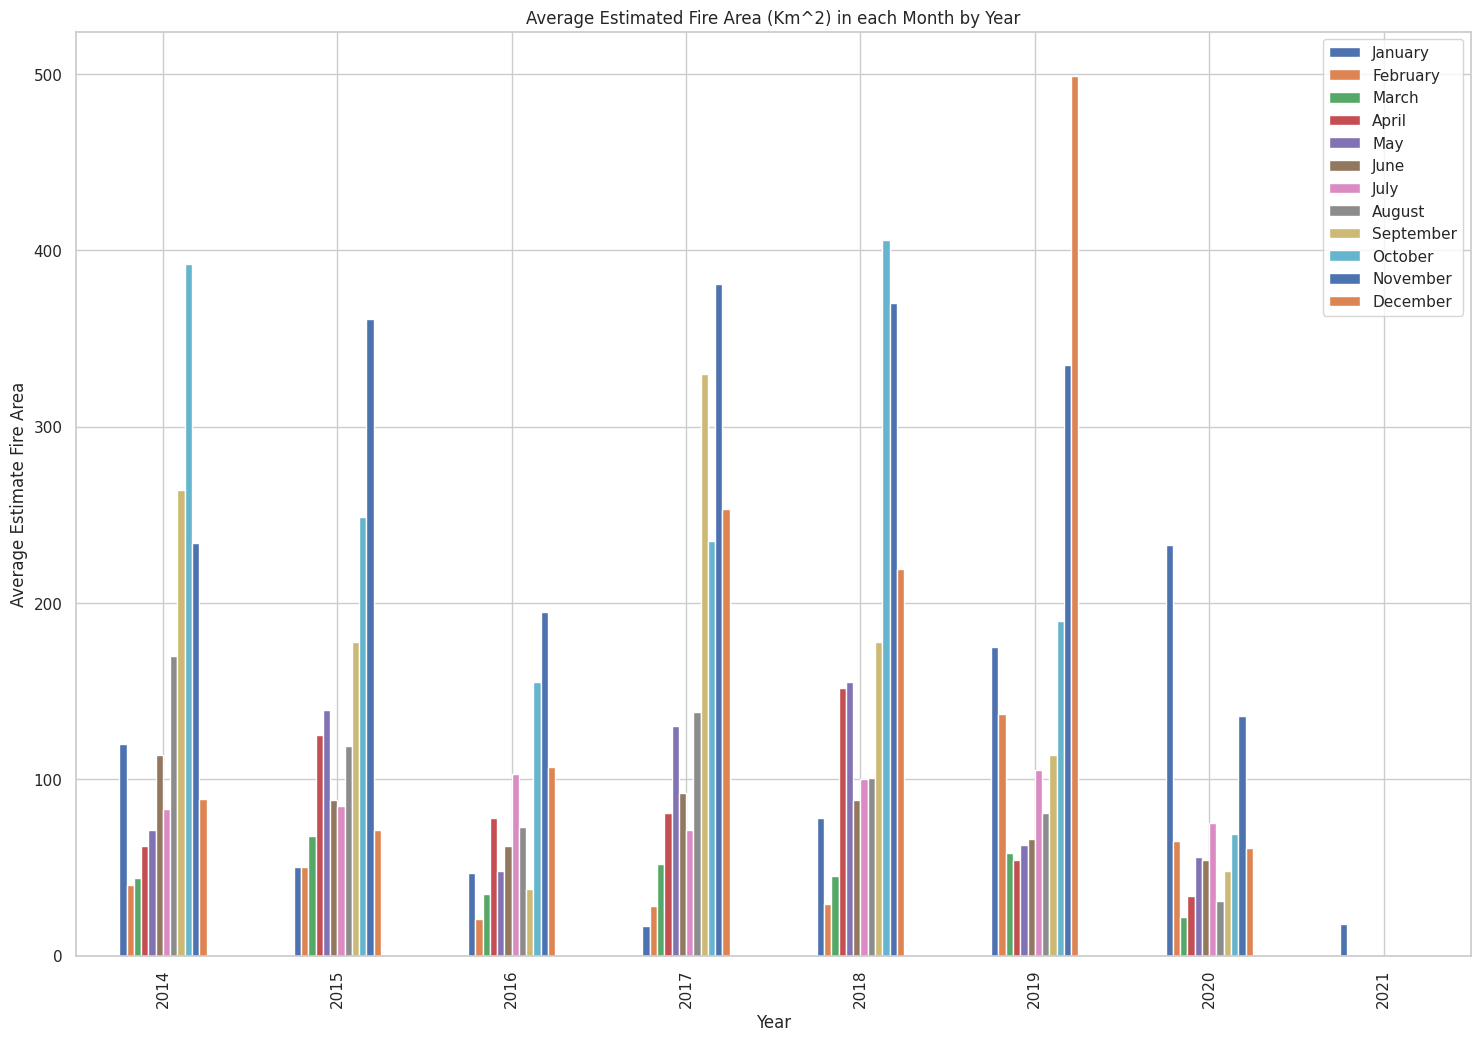

In [ ]:
df_fire_bright = analysis_df[['Region', 'Date', 'Estimated_fire_area', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power']].copy()
df_fire_bright['year'] = df_fire_bright['Date'].dt.year
df_fire_bright['month'] = df_fire_bright['Date'].dt.month
df_fire_bright['month_name'] = df_fire_bright['Date'].dt.strftime('%B')

f_area = df_fire_bright.groupby(['year', 'month'])[['Estimated_fire_area']].mean().round().reset_index()
f_area_wide = f_area.pivot(index='year', columns='month', values='Estimated_fire_area').fillna(0).copy()
list_of_months = pd.to_datetime(f_area['month'], format='%m').dt.strftime('%B').unique().tolist()

# Average Mean Estimated Fire Brightness (Kelvin) Per Month
f_bright = df_fire_bright.groupby(['year', 'month', 'month_name'])[['Mean_estimated_fire_brightness']].mean().round()
f_bright = f_bright.reset_index().drop('month', axis=1).rename(columns={'month_name': 'month'}).set_index(['year', 'month'])

plt.figure(figsize=(18, 9))
colors = sns.color_palette("husl", 7)

fig = sns.lineplot(x="month", y="Mean_estimated_fire_brightness", hue="year", data=f_bright, linewidth=3, palette=colors)
fig.set_title('Average Mean Estimated Fire Brightness (Kelvin) Per Month')
fig.set(xlabel='Months', ylabel='Average Mean Estimated Fire Brightness')
fig.legend().set_title('Year')

# Average Mean Estimated Fire Radiative Power (MW) Per Month
f_power = df_fire_bright.groupby(['year', 'month', 'month_name'], group_keys=False)[['Mean_estimated_fire_radiative_power']].mean().round()
f_power = f_power.reset_index().drop('month', axis=1).rename(columns={'month_name': 'month'}).set_index(['year', 'month'])

plt.figure(figsize=(18, 9))
colors = sns.color_palette("husl", 7)

fig = sns.lineplot(x="month", y="Mean_estimated_fire_radiative_power", hue="year", data=f_power, linewidth=3, palette=colors)
fig.set_title('Average Mean Estimated Fire Radiative Power (MW) Per Month')
fig.set(xlabel='Months', ylabel='Average Mean Estimated Fire Radiative Power')
fig.legend().set_title('Year')


f_area_wide.plot(kind='bar', figsize=(18, 12))
plt.legend(labels=list_of_months)
plt.title("Average Estimated Fire Area (Km^2) in each Month by Year")
plt.xlabel("Year")
plt.ylabel("Average Estimate Fire Area")
plt.show()

# **Model Building**

## Data Preperation

In [ ]:
# Load the data (assuming analysis_df is loaded as a DataFrame)
df = analysis_df.copy()

# 1. Data Preparation
# Target variable
y = df['Estimated_fire_area']

# Drop non-numeric or irrelevant columns
X = df.drop(columns=['Region', 'Date', 'Estimated_fire_area', 'Replaced'])

# One-hot encode categorical variables (if any remain)
X = pd.get_dummies(X, drop_first=True)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Linear Reggression

In [ ]:
# 2. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

# Linear Regression Metrics
lr_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
lr_mae = mean_absolute_error(y_val, y_pred_lr)
lr_r2 = r2_score(y_val, y_pred_lr)

print("Linear Regression:")
print(f"RMSE: {lr_rmse}, MAE: {lr_mae}, R²: {lr_r2}")

Linear Regression:
RMSE: 76.70642734213094, MAE: 31.29976077092097, R²: 0.9306386884766056


## Random Forest Regressor

In [ ]:
# 3. Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# Random Forest Metrics
rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf))
rf_mae = mean_absolute_error(y_val, y_pred_rf)
rf_r2 = r2_score(y_val, y_pred_rf)

print("\nRandom Forest Regressor:")
print(f"RMSE: {rf_rmse}, MAE: {rf_mae}, R²: {rf_r2}")


Random Forest Regressor:
RMSE: 35.618668541929516, MAE: 8.98117078887596, R²: 0.9850442172677084


## XGBoost Regressor

In [ ]:
# 4. XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

# XGBoost Metrics
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
xgb_mae = mean_absolute_error(y_val, y_pred_xgb)
xgb_r2 = r2_score(y_val, y_pred_xgb)

print("\nXGBoost Regressor:")
print(f"RMSE: {xgb_rmse}, MAE: {xgb_mae}, R²: {xgb_r2}")


XGBoost Regressor:
RMSE: 50.63454657339327, MAE: 11.274818052339283, R²: 0.969776299588188


## Evaluate Best Model

In [ ]:
# 5. Evaluate Best Model on Test Data
best_model = rf_model  # Replace with the model that performed best
y_pred_test = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("\nTest Performance of Best Model:")
print(f"RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")


Test Performance of Best Model:
RMSE: 35.326737363749494, MAE: 8.720608933964666, R²: 0.9830330526376856
